In [ ]:
# Import necessary libraries
# pandas: for data manipulation (though not heavily used here)
# pylops: for linear operators in seismic processing (used for AVO modeling)
# sklearn: for preprocessing (MinMaxScaler) and metrics
# tensorflow/keras: for building and training the deep learning model
# scipy: for signal processing (filtering) and I/O (.mat files)
# numpy: for numerical operations
# matplotlib: for plotting
import pandas as pd
import pylops
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow.keras import Sequential, layers, utils, losses
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.layers import Conv2D, Input, Conv1D
from tensorflow.keras.models import Model
from PIL import *
from sklearn import preprocessing
from scipy.signal import butter, filtfilt
from tensorflow.keras.layers import Dropout
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import scipy.io as sio
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load the ground truth model data (Vp, Vs, Density) from a .mat file
model_EI = sio.loadmat('model_EI.mat')
model_EI = model_EI['foo']
# Check the shape of the data
model_EI.shape

(200, 350, 3)

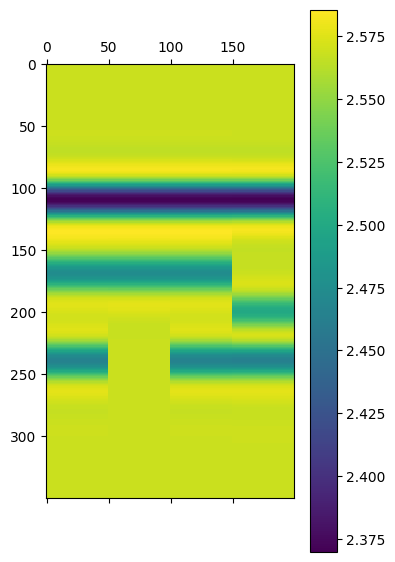

In [ ]:
# Visualize the Density (3rd channel, index 2) of the model
# Transpose for correct orientation
plt.matshow(model_EI[:,:,2].T)
plt.colorbar()

In [ ]:
# definition of Min-Max Normalization function
# scales data to range [0, 1] based on provided Min and Max values
def minmax(data, Min, Max):
    sample = (data - Min)/ (Max - Min)
    return sample

In [ ]:
# Load seismic data for different angle stacks: Near, Mid, Far
near = sio.loadmat('near.mat')
near = near['foo']
near = np.transpose(near,(1,2,0)) # Transpose to match dimensions

mid = sio.loadmat('mid.mat')
mid = mid['foo']
mid = np.transpose(mid,(1,2,0))

far = sio.loadmat('far.mat')
far = far['foo']
far = np.transpose(far,(1,2,0))
far.shape

(200, 350, 3)

In [ ]:
# Extract specific traces from the seismic data to be used as training samples
# Traces at indices 25, 75, 125, 175 are selected
near_1 = near[25,:,0]
near_2 = near[75,:,0]
near_3 = near[125,:,0]
near_4 = near[175,:,0]

mid_1 = mid[25,:,0]
mid_2 = mid[75,:,0]
mid_3 = mid[125,:,0]
mid_4 = mid[175,:,0]

far_1 = far[25,:,0]
far_2 = far[75,:,0]
far_3 = far[125,:,0]
far_4 = far[175,:,0]

In [ ]:
# Extract corresponding ground truth properties (Vp, Vs, Density) for the selected traces
# Index 0: Vp (P-wave velocity)
# Index 1: Vs (S-wave velocity)
# Index 2: Density
VP1 = model_EI[25,:,0]
VP2 = model_EI[75,:,0]
VP4 = model_EI[175,:,0]

VS1 = model_EI[25,:,1]
VS2 = model_EI[75,:,1]
VS4 = model_EI[175,:,1]

DEN1 = model_EI[25,:,2]
DEN2 = model_EI[75,:,2]
DEN4 = model_EI[175,:,2]

In [ ]:
# Calculate Min and Max values for each property and seismic stack to use for normalization
# Note: It seems to use the first trace (index 25) statistics for all, or maybe `near_1` represents the reference

near_1min = np.min(near_1)
near_1max = np.max(near_1)

mid_1min = np.min(mid_1)
mid_1max = np.max(mid_1)

far_1min = np.min(far_1)
far_1max = np.max(far_1)

VP_1min = np.min(VP1)
VP_1max = np.max(VP1)

VS_1min = np.min(VS1)
VS_1max = np.max(VS1)

DEN_1min = np.min(DEN1)
DEN_1max = np.max(DEN1)

In [ ]:
# Apply Min-Max normalization to the seismic traces
near_1S = minmax(near_1,near_1min,near_1max)
near_2S = minmax(near_2,near_1min,near_1max)
near_3S = minmax(near_3,near_1min,near_1max)
near_4S = minmax(near_4,near_1min,near_1max)

mid_1S = minmax(mid_1,near_1min,near_1max)
mid_2S = minmax(mid_2,near_1min,near_1max)
mid_3S = minmax(mid_3,near_1min,near_1max)
mid_4S = minmax(mid_4,near_1min,near_1max)

far_1S = minmax(far_1,near_1min,near_1max)
far_2S = minmax(far_2,near_1min,near_1max)
far_3S = minmax(far_3,near_1min,near_1max)
far_4S = minmax(far_4,near_1min,near_1max)

In [ ]:
# Apply Min-Max normalization to the ground truth (Vp, Vs, Density)
VP_1 = minmax(VP1,VP_1min,VP_1max)
VP_2 = minmax(VP2,VP_1min,VP_1max)
VP_4 = minmax(VP4,VP_1min,VP_1max)

VS_1 = minmax(VS1,VS_1min,VS_1max)
VS_2 = minmax(VS2,VS_1min,VS_1max)
VS_4 = minmax(VS4,VS_1min,VS_1max)

DEN_1 = minmax(DEN1,DEN_1min,DEN_1max)
DEN_2 = minmax(DEN2,DEN_1min,DEN_1max)
DEN_4 = minmax(DEN4,DEN_1min,DEN_1max)

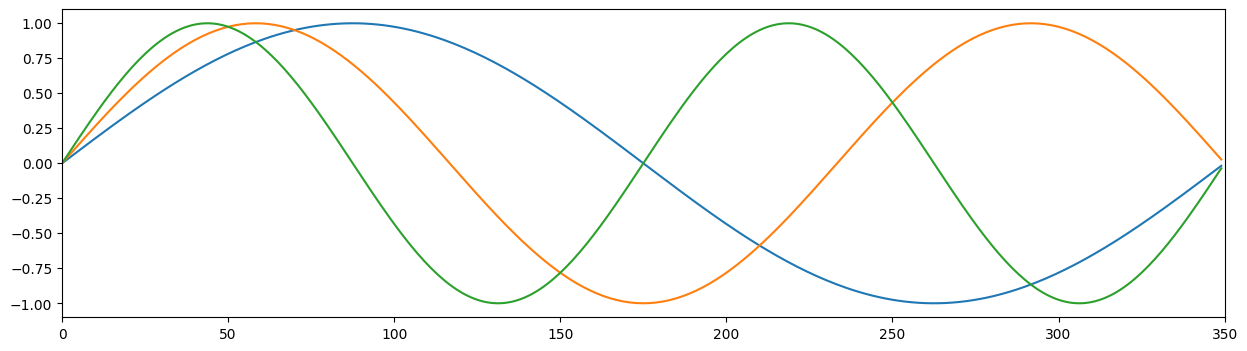

In [ ]:
# Generate synthetic phase curves
# These sine waves of different frequencies might be used to encode positional information or phase constraints
T = 350  # Total time samples
f = 1 / T  # Base frequency
x1 = np.arange(350)
Phase1 = np.sin(2 * np.pi * f * x1)  # 2nd harmonic

Phase2 = np.sin(3 * np.pi * f * x1)  # 3rd harmonic

Phase4 = np.sin(4 * np.pi * f * x1)  # 4th harmonic

plt.figure(figsize=(15,4))
plt.plot(x1, Phase1, label='Phase1') 
plt.plot(x1, Phase2, label='Phase2') 
plt.plot(x1, Phase4, label='Phase4') 
plt.xlim(0,350)
plt.legend()
plt.show()

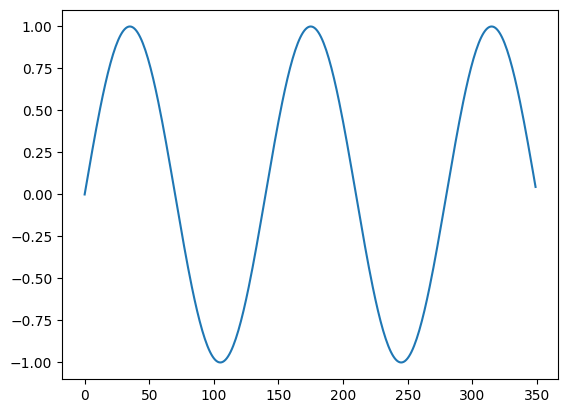

In [ ]:
# Generate another positional encoding signal (5th harmonic)
Positional = np.sin(5 * np.pi * f * x1)  
plt.plot(x1, Positional)

In [13]:
Phase1.shape,Positional.shape

((350,), (350,))

In [ ]:
# Create 2D datasets by repeating the 1D traces
# Each trace is repeated 50 times to create a block (batch-like structure)
near_1s = np.tile(near_1S, (50, 1))
near_2s = np.tile(near_2S, (50, 1))
near_3s = np.tile(near_3S, (50, 1))
near_4s = np.tile(near_4S, (50, 1))
# Concatenate blocks along the 0-axis (sample axis)
NEAR = np.concatenate((near_1s,near_2s,near_3s,near_4s),axis=0)

mid_1s = np.tile(mid_1S, (50, 1))
mid_2s = np.tile(mid_2S, (50, 1))
mid_3s = np.tile(near_3S, (50, 1)) # Note: using near_3S here? might be intentional or copy-paste error in original code
mid_4s = np.tile(near_4S, (50, 1)) # Note: using near_4S here?
MID = np.concatenate((mid_1s,mid_2s,mid_3s,mid_4s),axis=0)

far_1s = np.tile(far_1S, (50, 1))
far_2s = np.tile(far_2S, (50, 1))
far_3s = np.tile(far_3S, (50, 1))
far_4s = np.tile(far_4S, (50, 1))
FAR = np.concatenate((far_1s,far_2s,far_3s,far_4s),axis=0)

In [ ]:
# Stack the Near, Mid, Far data along the channel axis (axis 2)
# This creates a 3-channel input similar to an RGB image
SYN = np.stack((NEAR,MID,FAR),axis = 2)
SYN.shape

(200, 350, 3)

In [ ]:
# Prepare Phase and Positional embeddings
Phase_1 = np.tile(Phase1, (50, 1))
Phase_2 = np.tile(Phase2, (50, 1))
Phase_4 = np.tile(Phase4, (50, 1))
Positiona_l = np.tile(Positional, (200, 1)) # 200 matches the total length of concatenated NEAR/MID/FAR (50*4)
Positiona_l = np.expand_dims(Positiona_l,2)

In [ ]:
# Concatenate Phase information to match the data structure
PHASE = np.concatenate((Phase_1,Phase_2,Phase_1,Phase_4), axis=0) # Note: Phase_1 is used twice
PHASE = np.expand_dims(PHASE,2)
PHASE.shape

(200, 350, 1)

In [18]:
Positiona_l.shape,far.shape

((200, 350, 1), (200, 350, 3))

In [ ]:
# Combine Seismic Data (SYN), Phase Info (PHASE), and Positional Info (Positiona_l)
# Concatenate along channel axis. Result is likely 5 channels (3 + 1 + 1)
phase_data = np.concatenate((SYN,PHASE,Positiona_l),axis = 2)
phase_data.shape

(200, 350, 5)

In [ ]:
# Create a version of data without Phase info (only Seismic and Positional)
NO_phase_data = np.concatenate((SYN,Positiona_l),axis = 2)
NO_phase_data.shape

(200, 350, 4)

In [ ]:
# Select specific samples for training data
# It picks indices 25, 75, 175 from the prepared phase_data
Phase_train_data = np.stack((phase_data[25],phase_data[75],phase_data[175]),axis = 0)
Phase_train_data = np.expand_dims(Phase_train_data,2) # Add dimension for compatibility (Batch, Time, 1, Channels)?

Phase_train_data.shape

(3, 350, 1, 5)

In [ ]:
# Provide similar training data selection for the No-Phase dataset
NO_Phase_train_data = np.stack((NO_phase_data[25],NO_phase_data[75],NO_phase_data[175]),axis = 0)
NO_Phase_train_data = np.expand_dims(NO_Phase_train_data,2)
NO_Phase_train_data.shape

(3, 350, 1, 4)

In [ ]:
# Create Label definitions for training (Ground Truth)
# Stacking Vp, Vs, Density for the selected training indices corresponds to the input data
train_vp = np.stack((VP_1,VP_2,VP_4),axis = 0)
train_vs = np.stack((VS_1,VS_2,VS_4),axis = 0)
train_den = np.stack((DEN_1,DEN_2,DEN_4),axis = 0)
train_label = np.stack((train_vp,train_vs,train_den),axis=2)
train_label.shape

(3, 350, 3)

In [ ]:
# Import layers and functions for the Deep Learning Model
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Reshape, Multiply, Add, Permute, GRU
from tensorflow.keras.models import Model
import numpy as np
from scipy import signal
from pylops.utils.wavelets import ricker # Ricker wavelet for seismic modeling

In [ ]:
# Reverse Min-Max normalization to get back to original physical units
def reverse(data, Min, Max):
        sample = data * (Max - Min) + Min
        return sample

# Physics-informed loss function: Seismic Consistency Loss
# This calculates the difference between the input real seismic data (S2_) and 
# the synthetic seismic generated from the predicted rock properties (Vp, Vs, Density).
def seismic_loss1(S2_, predictions):
    vsvp = 0.5 # assumed Vs/Vp ratio for background
    ntheta = 3 # number of angles (Near, Mid, Far)
    thetamin, thetamax = 10, 30 # Angle range
    theta = np.linspace(thetamin, thetamax, ntheta)

    nt0 = train_label.shape[1] # number of time samples
    dt0 = 0.5e-3 # sampling interval (seconds)
    t0 = np.arange(nt0) * dt0
    ntwav = 180 # wavelet length
    wavelet = ricker(t0[:ntwav//2+1], 25)[0] # Extract 25Hz Ricker wavelet

    # Reverse normalization of predictions to get physical parameters
    Re_FPVP = reverse(predictions[:, :, 0], VP_1min, VP_1max)
    Re_FPVS = reverse(predictions[:, :, 1], VS_1min, VS_1max)
    Re_FPDN = reverse(predictions[:, :, 2], DEN_1min, DEN_1max)
    
    Re_FP = tf.stack((Re_FPVP, Re_FPVS, Re_FPDN), axis=2)
    # Use Logarithm of properties for AVO linearization (Aki-Richards)
    s1 = tf.math.log(Re_FP)

    SYN = tf.zeros((3, train_label.shape[1], ntheta), dtype=tf.float32)
    SYN_var = tf.Variable(SYN)

    # Forward Modelling Loop over the batch (size 3)
    for i in range(3):
        m = s1[i, :, :]
        # Pylops AVO modelling operator (Prestack Linear Modelling)
        PPop_dense = pylops.avo.prestack.PrestackLinearModelling(wavelet, theta, vsvp=vsvp, nt0=nt0, linearization="akirich", explicit=True)
        # Generate Synthetic Seismic Data
        dPP_dense = PPop_dense * m.ravel()
        tf_reshaped = tf.reshape(dPP_dense, [1,nt0, ntheta,])
        SYN_var[i].assign(tf.cast(tf_reshaped, tf.float32))
    
    # Return Mean Squared Error between Real and Synthetic Seismic
    return tf.reduce_mean(tf.square(S2_ - SYN_var))

In [ ]:
# Supervised Loss (Well Loss)
# Direct comparison between predicted properties and ground truth labels (at well locations)
def well_loss2(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

In [ ]:
# Low-frequency Regularization Loss
# Seismic data lacks low frequencies. This loss constrains the low-frequency component 
# of the predictions to match the low-frequency component of the true model.
def lowmodel_loss3(y_true3, y_pred3):
    nfilt = 3
    cutofffr = 0.03 # Normalized Cutoff frequency
    b, a = signal.butter(nfilt, cutofffr) # Design Butterworth low-pass filter
   
    # Filter predictions
    Vpprior = signal.filtfilt(b, a, y_pred3[:, :, 0])
    Vsprior = signal.filtfilt(b, a, y_pred3[:, :, 1])
    Rhobprior = signal.filtfilt(b, a, y_pred3[:, :, 2])
    
    # Filter ground truth labels
    Vpprior_label = signal.filtfilt(b, a, y_true3[:, :, 0])
    Vsprior_label = signal.filtfilt(b, a, y_true3[:, :, 1])
    Rhobprior_label = signal.filtfilt(b, a, y_true3[:, :, 2])
    
    Re_label = tf.stack((Vpprior_label,Vsprior_label,Rhobprior_label),axis = 2)
    Re_FP = tf.stack((Vpprior,Vsprior,Rhobprior),axis = 2)

    # Minimize difference in low-frequency content
    return tf.reduce_mean(tf.square(Re_label-Re_FP))

In [30]:
from tensorflow.keras.layers import Activation

In [ ]:
# Self-Attention Block 
# Computes attention scores to weigh the importance of different time steps/features
def attention_3d_block1(inputs): # Input shape: (Batch, Time, Units)
    # Permute to (Batch, Units, Time)
    a = Permute((2, 1))(inputs) 

    DK = 63 # Dimension of Key/Query/Value

    WQ = Dense(DK, activation='softmax')(a)  
    WK = Dense(DK, activation='softmax')(a)
    WV = Dense(DK, activation='softmax')(a)

    # Compute Query, Key, Value matrices
    Q = tf.matmul(inputs,WQ) 
    K = tf.matmul(inputs,WK)
    V = tf.matmul(inputs,WV)
    
    # Calculate Attention Scores
    # (batch_size, lstm_units, time_steps) -> (batch_size, time_steps, lstm_units)
    KT = Permute((2, 1), name='attention_vec')(K) 
    score = tf.matmul(Q,KT) # Q * K^T
    
    # Scale scores
    import math
    DK = math.sqrt(DK)
    res = score / DK 
    X = Activation('softmax')(res) # Softmax to get probabilities
    
    # Apply attention to Value
    result = tf.matmul(X,V) 
    return result

In [ ]:
# Define the Hybrid Model architecture (CNN + GRU + Attention)
# SAGCN: Likely stands for Spatial-Attention Gated Recurrent Network or similar naming convention
def face_model_SAGCN(input_size= Phase_train_data.shape[-3:]):
    input_size=Phase_train_data.shape[-3:]
    input_ = Input(input_size)
    
    # CNN Branch: Extract local features using multi-scale convolutions
    conv1 = Conv2D(7, (3,3), padding="same", activation="relu")(input_)
    conv2 = Conv2D(9, (5,5), padding="same", activation="relu")(conv1)
    conv3 = Conv2D(9, (7,7), padding="same", activation="relu")(conv2)
    # Reshape CNN output to match GRU sequence format
    Spatial = Reshape((phase_data.shape[1], 9))(conv3)
    
    # RNN Branch: Capture temporal/sequential dependencies using stacked GRUs
    input_1 = Reshape((phase_data.shape[1], phase_data.shape[2]))(input_)
    G1 = GRU(9, return_sequences=True, activation='relu')(input_1)
    G2 = GRU(9, return_sequences=True, activation='relu')(G1)
    G3 = GRU(9, return_sequences=True, activation='relu')(G2)
    
    # Feature Fusion: Combine Spatial (CNN) and Temporal (GRU) features
    a = G3 + Spatial
    
    # Apply Self-Attention to the fused features
    result = attention_3d_block1(a)
    
    # Final dense layers to predict Vp, Vs, Density (3 parameters)
    flatten = Flatten()(result)
    output = Dense(phase_data.shape[1]*3)(flatten)
    output1 = Reshape((phase_data.shape[1],3))(output)
    
    face_model = Model(inputs=input_, outputs=output1)
    return face_model

In [ ]:
# Initialize model and optimizer
from tqdm import tqdm
input_size = Phase_train_data.shape[-3:]
face_model = face_model_SAGCN(input_size)
optimizer = tf.keras.optimizers.Adam()

In [ ]:
# Custom Training Loop using GradientTape
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
num_epochs = 300
for epoch in tqdm(range(num_epochs)):
    with tf.GradientTape() as tape:
        # Forward pass: Generate predictions
        predictions = face_model(Phase_train_data, training=True)

        # Calculate Losses
        # Loss 1: Physics-based Seismic Loss (matches synthetic seismic to observed seismic)
        loss1 = seismic_loss1(Phase_train_data[:,:,0,:3], predictions)
        loss11 = tf.cast(loss1,tf.float32)
        
        # Loss 2: Supervised Well Loss (matches predictions to well log data)
        loss2 = well_loss2(train_label, predictions)
        
        # Loss 3: Low-frequency Constraint (matches LF trend of predictions to true model)
        loss3 = lowmodel_loss3(train_label, predictions)
        
        # Total Loss
        total_loss = loss11 + loss2 + loss3

    # Backpropagation: Calculate gradients and update weights
    gradients = tape.gradient(total_loss, face_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, face_model.trainable_variables))

    # print(f"Epoch {epoch+1}, Total Loss: {total_loss.numpy()}, Loss1: {loss1.numpy()}, Loss2: {loss2.numpy()}, Loss3: {loss3.numpy()}")

  0%|▎                                                                                 | 1/300 [00:05<25:21,  5.09s/it]

Epoch 1, Total Loss: 1.076160239977721, Loss1: 0.4315307755151493, Loss2: 0.3290158674410092, Loss3: 0.3156135988970328


  1%|▌                                                                                 | 2/300 [00:10<24:59,  5.03s/it]

Epoch 2, Total Loss: 0.8299387234316391, Loss1: 0.4326061130439909, Loss2: 0.20407036925653937, Loss3: 0.19326225313902795


  1%|▊                                                                                 | 3/300 [00:15<25:06,  5.07s/it]

Epoch 3, Total Loss: 0.6379435904924208, Loss1: 0.43374964324561915, Loss2: 0.10632569061910599, Loss3: 0.09786825392490477


  1%|█                                                                                 | 4/300 [00:19<24:27,  4.96s/it]

Epoch 4, Total Loss: 0.5245399207445597, Loss1: 0.4346976728095237, Loss2: 0.0480763082000198, Loss3: 0.04176592491865487


  2%|█▎                                                                                | 5/300 [00:24<24:20,  4.95s/it]

Epoch 5, Total Loss: 0.49684941390980886, Loss1: 0.43516885714845255, Loss2: 0.033162043121352985, Loss3: 0.028518508445621406


  2%|█▋                                                                                | 6/300 [00:29<23:39,  4.83s/it]

Epoch 6, Total Loss: 0.5176438513460773, Loss1: 0.434943033995722, Loss2: 0.043344751695196054, Loss3: 0.03935607930710077


  2%|█▉                                                                                | 7/300 [00:34<23:29,  4.81s/it]

Epoch 7, Total Loss: 0.5260718260521204, Loss1: 0.43415712293213965, Loss2: 0.048033084458063195, Loss3: 0.043881608491640293


  3%|██▏                                                                               | 8/300 [00:38<23:03,  4.74s/it]

Epoch 8, Total Loss: 0.5160844232717662, Loss1: 0.4332723290248524, Loss2: 0.043700280292743685, Loss3: 0.03911181102597378


  3%|██▍                                                                               | 9/300 [00:43<22:47,  4.70s/it]

Epoch 9, Total Loss: 0.5008197985293557, Loss1: 0.43260900183044726, Loss2: 0.03654292755244259, Loss3: 0.031667879115569654


  3%|██▋                                                                              | 10/300 [00:48<22:36,  4.68s/it]

Epoch 10, Total Loss: 0.4895743846698104, Loss1: 0.43227586288142283, Loss2: 0.031074381036616736, Loss3: 0.026224142131499928


  4%|██▉                                                                              | 11/300 [00:52<22:23,  4.65s/it]

Epoch 11, Total Loss: 0.4831677549108882, Loss1: 0.4322444147729249, Loss2: 0.027740192435317005, Loss3: 0.02318314242399649


  4%|███▏                                                                             | 12/300 [00:57<21:57,  4.58s/it]

Epoch 12, Total Loss: 0.47897623285216895, Loss1: 0.43241796281250433, Loss2: 0.025350952974888045, Loss3: 0.021207320902442636


  4%|███▌                                                                             | 13/300 [01:01<22:03,  4.61s/it]

Epoch 13, Total Loss: 0.47508253448436616, Loss1: 0.4326853655589587, Loss2: 0.023076679137183892, Loss3: 0.019320480133559217


  5%|███▊                                                                             | 14/300 [01:06<22:08,  4.65s/it]

Epoch 14, Total Loss: 0.47103535572022326, Loss1: 0.4329612215950945, Loss2: 0.020777682956931165, Loss3: 0.017296447253648557


  5%|████                                                                             | 15/300 [01:10<21:36,  4.55s/it]

Epoch 15, Total Loss: 0.466964217672259, Loss1: 0.4331967893512133, Loss2: 0.018548393225492992, Loss3: 0.015219041380970098


  5%|████▎                                                                            | 16/300 [01:15<21:44,  4.59s/it]

Epoch 16, Total Loss: 0.4631133544413789, Loss1: 0.43337295791271274, Loss2: 0.016502809032071686, Loss3: 0.013237600815877652


  6%|████▌                                                                            | 17/300 [01:20<21:45,  4.61s/it]

Epoch 17, Total Loss: 0.4597422766471769, Loss1: 0.4334887675402529, Loss2: 0.014747020750929795, Loss3: 0.011506499478018899


  6%|████▊                                                                            | 18/300 [01:24<21:31,  4.58s/it]

Epoch 18, Total Loss: 0.45711517272507207, Loss1: 0.4335532964505023, Loss2: 0.01338877003169554, Loss3: 0.010173094444856643


  6%|█████▏                                                                           | 19/300 [01:29<21:22,  4.56s/it]

Epoch 19, Total Loss: 0.45548094746012363, Loss1: 0.433579394172185, Loss2: 0.01253398362441938, Loss3: 0.009367578555095138


  7%|█████▍                                                                           | 20/300 [01:33<21:13,  4.55s/it]

Epoch 20, Total Loss: 0.45493224134894067, Loss1: 0.43358057734450445, Loss2: 0.01221823640134463, Loss3: 0.009133427574091392


  7%|█████▋                                                                           | 21/300 [01:38<21:05,  4.54s/it]

Epoch 21, Total Loss: 0.4552713286039555, Loss1: 0.4335687783920366, Loss2: 0.012339642769197237, Loss3: 0.009362910180919167


  7%|█████▉                                                                           | 22/300 [01:42<21:06,  4.56s/it]

Epoch 22, Total Loss: 0.45598314374391985, Loss1: 0.4335525908176101, Loss2: 0.012643695485903536, Loss3: 0.009786855265233686


  8%|██████▏                                                                          | 23/300 [01:47<21:10,  4.59s/it]

Epoch 23, Total Loss: 0.45638367576914246, Loss1: 0.43353633631306265, Loss2: 0.012794875536086069, Loss3: 0.010052449505975098


  8%|██████▍                                                                          | 24/300 [01:52<21:00,  4.57s/it]

Epoch 24, Total Loss: 0.4559028756626583, Loss1: 0.43352009580280537, Loss2: 0.012515074789792115, Loss3: 0.009867692411486152


  8%|██████▊                                                                          | 25/300 [01:56<21:06,  4.61s/it]

Epoch 25, Total Loss: 0.45434956119772935, Loss1: 0.433500925119281, Loss2: 0.011713456834658402, Loss3: 0.009135188597308608


  9%|███████                                                                          | 26/300 [02:01<21:11,  4.64s/it]

Epoch 26, Total Loss: 0.452000301794668, Loss1: 0.4334749904815943, Loss2: 0.010529557191431328, Loss3: 0.007995756857951633


  9%|███████▎                                                                         | 27/300 [02:05<20:46,  4.56s/it]

Epoch 27, Total Loss: 0.4494617511939517, Loss1: 0.43343984625803045, Loss2: 0.009264601235054076, Loss3: 0.0067572991517076955


  9%|███████▌                                                                         | 28/300 [02:10<20:59,  4.63s/it]

Epoch 28, Total Loss: 0.4473928468164855, Loss1: 0.43339589777534776, Loss2: 0.00824352813063929, Loss3: 0.005753426304178149


 10%|███████▊                                                                         | 29/300 [02:15<20:43,  4.59s/it]

Epoch 29, Total Loss: 0.4462363284288641, Loss1: 0.4333469354499113, Loss2: 0.007681786844249276, Loss3: 0.005207614418629783


 10%|████████                                                                         | 30/300 [02:19<20:45,  4.61s/it]

Epoch 30, Total Loss: 0.4460768504227898, Loss1: 0.4332991214436379, Loss2: 0.0076156377589621784, Loss3: 0.0051620884229523385


 10%|████████▎                                                                        | 31/300 [02:24<20:35,  4.59s/it]

Epoch 31, Total Loss: 0.44666075094073787, Loss1: 0.433259497500943, Loss2: 0.00791308066963866, Loss3: 0.005488183118999614


 11%|████████▋                                                                        | 32/300 [02:28<20:07,  4.51s/it]

Epoch 32, Total Loss: 0.4475393758801787, Loss1: 0.4332340751123948, Loss2: 0.008346501834458687, Loss3: 0.00595880827461714


 11%|████████▉                                                                        | 33/300 [02:33<19:56,  4.48s/it]

Epoch 33, Total Loss: 0.4482588185318675, Loss1: 0.43322655283727984, Loss2: 0.008688113509082983, Loss3: 0.006344149436923303


 11%|█████████▏                                                                       | 34/300 [02:37<20:10,  4.55s/it]

Epoch 34, Total Loss: 0.44851519811357693, Loss1: 0.4332377541103142, Loss2: 0.008787556230302557, Loss3: 0.006489880624195386


 12%|█████████▍                                                                       | 35/300 [02:42<20:37,  4.67s/it]

Epoch 35, Total Loss: 0.4482234732088822, Loss1: 0.4332655921419895, Loss2: 0.008605690106046964, Loss3: 0.006352186474646138


 12%|█████████▋                                                                       | 36/300 [02:47<20:48,  4.73s/it]

Epoch 36, Total Loss: 0.44749872284055736, Loss1: 0.4333058423914285, Loss2: 0.008204235163354561, Loss3: 0.0059886579137903555


 12%|█████████▉                                                                       | 37/300 [02:52<20:49,  4.75s/it]

Epoch 37, Total Loss: 0.44657788728320075, Loss1: 0.43335263899790855, Loss2: 0.007705875444863563, Loss3: 0.005519362626453612


 13%|██████████▎                                                                      | 38/300 [02:57<20:34,  4.71s/it]

Epoch 38, Total Loss: 0.4457241051739299, Loss1: 0.4333995765872644, Loss2: 0.007245772003151723, Loss3: 0.005078745301133996


 13%|██████████▌                                                                      | 39/300 [03:01<20:41,  4.76s/it]

Epoch 39, Total Loss: 0.44514001322653785, Loss1: 0.4334402362097777, Loss2: 0.0069278530582064695, Loss3: 0.004771921930950386


 13%|██████████▊                                                                      | 40/300 [03:06<20:35,  4.75s/it]

Epoch 40, Total Loss: 0.44491039320605635, Loss1: 0.43346907769520493, Loss2: 0.006795882172107936, Loss3: 0.004645424148496166


 14%|███████████                                                                      | 41/300 [03:11<20:50,  4.83s/it]

Epoch 41, Total Loss: 0.44499037203085556, Loss1: 0.4334820900583083, Loss2: 0.006827618234322292, Loss3: 0.004680673098519928


 14%|███████████▎                                                                     | 42/300 [03:16<20:41,  4.81s/it]

Epoch 42, Total Loss: 0.4452382972257202, Loss1: 0.4334773053415699, Loss2: 0.0069513661975020725, Loss3: 0.004809618701786848


 14%|███████████▌                                                                     | 43/300 [03:20<20:18,  4.74s/it]

Epoch 43, Total Loss: 0.4454806058407745, Loss1: 0.4334552831960454, Loss2: 0.007078807292810213, Loss3: 0.004946510137777536


 15%|███████████▉                                                                     | 44/300 [03:25<20:03,  4.70s/it]

Epoch 44, Total Loss: 0.4455820797011545, Loss1: 0.4334191544098459, Loss2: 0.007140367701527687, Loss3: 0.005022544004173903


 15%|████████████▏                                                                    | 45/300 [03:30<19:49,  4.66s/it]

Epoch 45, Total Loss: 0.4454891026330419, Loss1: 0.4333742794088355, Loss2: 0.00710713499446286, Loss3: 0.005007681940642032


 15%|████████████▍                                                                    | 46/300 [03:35<20:15,  4.79s/it]

Epoch 46, Total Loss: 0.4452335207982525, Loss1: 0.43332731052825796, Loss2: 0.0069929202024757746, Loss3: 0.004913283357922735


 16%|████████████▋                                                                    | 47/300 [03:39<20:02,  4.75s/it]

Epoch 47, Total Loss: 0.44490164317556197, Loss1: 0.43328545383284245, Loss2: 0.006838669015475386, Loss3: 0.0047775291851873385


 16%|████████████▉                                                                    | 48/300 [03:44<20:10,  4.80s/it]

Epoch 48, Total Loss: 0.4445872621434477, Loss1: 0.43325488138861074, Loss2: 0.006689223813939346, Loss3: 0.004643170537378829


 16%|█████████████▏                                                                   | 49/300 [03:49<19:52,  4.75s/it]

Epoch 49, Total Loss: 0.4443560704048149, Loss1: 0.43324010316894584, Loss2: 0.0065756035972245755, Loss3: 0.004540351165042694


 17%|█████████████▌                                                                   | 50/300 [03:54<20:02,  4.81s/it]

Epoch 50, Total Loss: 0.444229629109822, Loss1: 0.4332430518175438, Loss2: 0.006507442453477915, Loss3: 0.0044791205838800915


 17%|█████████████▊                                                                   | 51/300 [03:59<20:01,  4.82s/it]

Epoch 51, Total Loss: 0.44419259579375053, Loss1: 0.4332629088904558, Loss2: 0.006476816000273645, Loss3: 0.004452865374302683


 17%|██████████████                                                                   | 52/300 [04:03<19:47,  4.79s/it]

Epoch 52, Total Loss: 0.444210634357314, Loss1: 0.43329630427350213, Loss2: 0.006467472371948676, Loss3: 0.004446868965116943


 18%|██████████████▎                                                                  | 53/300 [04:08<19:42,  4.79s/it]

Epoch 53, Total Loss: 0.444247786746341, Loss1: 0.43333768362786174, Loss2: 0.006463523427908249, Loss3: 0.004446574872387888


 18%|██████████████▌                                                                  | 54/300 [04:13<19:39,  4.79s/it]

Epoch 54, Total Loss: 0.44427746224145187, Loss1: 0.43338043882023425, Loss2: 0.00645461099111707, Loss3: 0.004442426273985965


 18%|██████████████▊                                                                  | 55/300 [04:18<19:19,  4.73s/it]

Epoch 55, Total Loss: 0.44428576951731646, Loss1: 0.433417757696244, Loss2: 0.006437072903646881, Loss3: 0.004430929327368927


 19%|███████████████                                                                  | 56/300 [04:22<19:23,  4.77s/it]

Epoch 56, Total Loss: 0.4442673275604211, Loss1: 0.43344388192763783, Loss2: 0.006411276964154912, Loss3: 0.0044121764755539325


 19%|███████████████▍                                                                 | 57/300 [04:27<18:54,  4.67s/it]

Epoch 57, Total Loss: 0.44422161541012267, Loss1: 0.4334552689395524, Loss2: 0.0063789886336663645, Loss3: 0.004387368168591895


 19%|███████████████▋                                                                 | 58/300 [04:31<18:42,  4.64s/it]

Epoch 58, Total Loss: 0.4441501303673849, Loss1: 0.43345105198664213, Loss2: 0.00634169011214662, Loss3: 0.00435738377483054


 20%|███████████████▉                                                                 | 59/300 [04:36<18:57,  4.72s/it]

Epoch 59, Total Loss: 0.4440564411065309, Loss1: 0.43343326811973776, Loss2: 0.006300377877152627, Loss3: 0.00432279873543599


 20%|████████████████▏                                                                | 60/300 [04:41<19:00,  4.75s/it]

Epoch 60, Total Loss: 0.4439486214092303, Loss1: 0.4334062379369707, Loss2: 0.006257014970274379, Loss3: 0.004285372651419311


 20%|████████████████▍                                                                | 61/300 [04:46<18:46,  4.72s/it]

Epoch 61, Total Loss: 0.44383956831445676, Loss1: 0.43337550869967806, Loss2: 0.006215280388548603, Loss3: 0.004248780332753204


 21%|████████████████▋                                                                | 62/300 [04:50<18:32,  4.67s/it]

Epoch 62, Total Loss: 0.44374376168434726, Loss1: 0.43334660155693827, Loss2: 0.006179585104196919, Loss3: 0.004217577239711482


 21%|█████████████████                                                                | 63/300 [04:55<18:25,  4.66s/it]

Epoch 63, Total Loss: 0.443672667558305, Loss1: 0.43332398529002103, Loss2: 0.006153327044290759, Loss3: 0.004195361136267639


 21%|█████████████████▎                                                               | 64/300 [05:00<18:43,  4.76s/it]

Epoch 64, Total Loss: 0.4436297497011836, Loss1: 0.43331030321393715, Loss2: 0.006136801127272071, Loss3: 0.0041826484621408765


 22%|█████████████████▌                                                               | 65/300 [05:05<19:12,  4.91s/it]

Epoch 65, Total Loss: 0.4436091925924499, Loss1: 0.4333062536661786, Loss2: 0.006126651731572204, Loss3: 0.004176293864951779


 22%|█████████████████▊                                                               | 66/300 [05:11<20:34,  5.28s/it]

Epoch 66, Total Loss: 0.4435983198485211, Loss1: 0.43331078381564314, Loss2: 0.006116959421530409, Loss3: 0.004170583478061871


 22%|██████████████████                                                               | 67/300 [05:18<21:55,  5.65s/it]

Epoch 67, Total Loss: 0.4435832248135123, Loss1: 0.43332164940840523, Loss2: 0.006101807443343782, Loss3: 0.004159762573568202


 23%|██████████████████▎                                                              | 68/300 [05:24<22:07,  5.72s/it]

Epoch 68, Total Loss: 0.4435542516472926, Loss1: 0.4333360225747622, Loss2: 0.006077752495693587, Loss3: 0.004140479635607824


 23%|██████████████████▋                                                              | 69/300 [05:29<21:15,  5.52s/it]

Epoch 69, Total Loss: 0.44351015802614424, Loss1: 0.4333510244799799, Loss2: 0.0060456108267209294, Loss3: 0.004113537115271051


 23%|██████████████████▉                                                              | 70/300 [05:34<20:51,  5.44s/it]

Epoch 70, Total Loss: 0.4434571217303852, Loss1: 0.4333642591266828, Loss2: 0.0060096965831926905, Loss3: 0.004083153029577776


 24%|███████████████████▏                                                             | 71/300 [05:39<20:15,  5.31s/it]

Epoch 71, Total Loss: 0.4434036725403919, Loss1: 0.43337400038396623, Loss2: 0.005975261903852952, Loss3: 0.004054422961825854


 24%|███████████████████▍                                                             | 72/300 [05:44<19:37,  5.16s/it]

Epoch 72, Total Loss: 0.4433573806199236, Loss1: 0.43337946182475945, Loss2: 0.005946544818385371, Loss3: 0.004031364499505728


 24%|███████████████████▋                                                             | 73/300 [05:49<19:15,  5.09s/it]

Epoch 73, Total Loss: 0.4433193634196453, Loss1: 0.43338057539725233, Loss2: 0.005924212933602635, Loss3: 0.0040145764980818455


 25%|███████████████████▉                                                             | 74/300 [05:54<19:22,  5.14s/it]

Epoch 74, Total Loss: 0.4432856429821572, Loss1: 0.43337799420283857, Loss2: 0.005905937628631777, Loss3: 0.004001724167612328


 25%|████████████████████▎                                                            | 75/300 [05:59<18:47,  5.01s/it]

Epoch 75, Total Loss: 0.44324887064370916, Loss1: 0.43337280003445294, Loss2: 0.005887415746601559, Loss3: 0.0039886593152899654


 25%|████████████████████▌                                                            | 76/300 [06:03<18:10,  4.87s/it]

Epoch 76, Total Loss: 0.44320374662538026, Loss1: 0.433366355287267, Loss2: 0.005865224957133623, Loss3: 0.0039721633880647885


 26%|████████████████████▊                                                            | 77/300 [06:08<18:03,  4.86s/it]

Epoch 77, Total Loss: 0.4431483855702172, Loss1: 0.4333599139163946, Loss2: 0.005837695065239137, Loss3: 0.003950769526431935


 26%|█████████████████████                                                            | 78/300 [06:13<17:36,  4.76s/it]

Epoch 78, Total Loss: 0.44308546330676335, Loss1: 0.43335448647933655, Loss2: 0.005805577573493115, Loss3: 0.003925388777398694


 26%|█████████████████████▎                                                           | 79/300 [06:17<17:19,  4.70s/it]

Epoch 79, Total Loss: 0.4430195004753571, Loss1: 0.4333507336484876, Loss2: 0.005770765124970523, Loss3: 0.003897993487135822


 27%|█████████████████████▌                                                           | 80/300 [06:22<16:51,  4.60s/it]

Epoch 80, Total Loss: 0.442953718371849, Loss1: 0.43334883552761333, Loss2: 0.0057347602346285425, Loss3: 0.003870123622602515


 27%|█████████████████████▊                                                           | 81/300 [06:26<16:37,  4.55s/it]

Epoch 81, Total Loss: 0.44288861702569415, Loss1: 0.4333485843071176, Loss2: 0.00569788314484136, Loss3: 0.0038421377848139805


 27%|██████████████████████▏                                                          | 82/300 [06:30<16:16,  4.48s/it]

Epoch 82, Total Loss: 0.4428223972228859, Loss1: 0.4333495836455638, Loss2: 0.005659448459459076, Loss3: 0.003813369190749181


 28%|██████████████████████▍                                                          | 83/300 [06:35<16:06,  4.45s/it]

Epoch 83, Total Loss: 0.4427520474837354, Loss1: 0.43335121728280307, Loss2: 0.005618186501621843, Loss3: 0.003782642281704655


 28%|██████████████████████▋                                                          | 84/300 [06:39<16:00,  4.45s/it]

Epoch 84, Total Loss: 0.44267490004707893, Loss1: 0.43335295528219225, Loss2: 0.005572966827360671, Loss3: 0.00374898598461081


 28%|██████████████████████▉                                                          | 85/300 [06:44<15:51,  4.42s/it]

Epoch 85, Total Loss: 0.4425893212642591, Loss1: 0.43335447864105736, Loss2: 0.005523009722523242, Loss3: 0.0037118443881866635


 29%|███████████████████████▏                                                         | 86/300 [06:48<15:47,  4.43s/it]

Epoch 86, Total Loss: 0.44249401410989114, Loss1: 0.43335562517622667, Loss2: 0.005467596931818729, Loss3: 0.003670787733950085


 29%|███████████████████████▍                                                         | 87/300 [06:52<15:35,  4.39s/it]

Epoch 87, Total Loss: 0.44238759429919, Loss1: 0.4333564845133618, Loss2: 0.005405858929096866, Loss3: 0.003625241658621577


 29%|███████████████████████▊                                                         | 88/300 [06:57<15:36,  4.42s/it]

Epoch 88, Total Loss: 0.4422678344034241, Loss1: 0.4333572345965782, Loss2: 0.005336438688882528, Loss3: 0.003574156945010321


 30%|████████████████████████                                                         | 89/300 [07:01<15:26,  4.39s/it]

Epoch 89, Total Loss: 0.4421318832895249, Loss1: 0.4333580441445446, Loss2: 0.005257659655034627, Loss3: 0.003516180202254558


 30%|████████████████████████▎                                                        | 90/300 [07:06<15:20,  4.38s/it]

Epoch 90, Total Loss: 0.44197718187334517, Loss1: 0.43335897682607366, Loss2: 0.0051680612822031, Loss3: 0.0034501532869123572


 30%|████████████████████████▌                                                        | 91/300 [07:10<15:23,  4.42s/it]

Epoch 91, Total Loss: 0.4418013917420291, Loss1: 0.43335993785297355, Loss2: 0.005066313845913823, Loss3: 0.003375127115246721


 31%|████████████████████████▊                                                        | 92/300 [07:14<15:13,  4.39s/it]

Epoch 92, Total Loss: 0.4416022000538408, Loss1: 0.4333607456983078, Loss2: 0.00495115842989258, Loss3: 0.003290286180375248


 31%|█████████████████████████                                                        | 93/300 [07:19<15:02,  4.36s/it]

Epoch 93, Total Loss: 0.44137672763325303, Loss1: 0.43336124532092846, Loss2: 0.004820954746309806, Loss3: 0.0031945406062120593


 31%|█████████████████████████▍                                                       | 94/300 [07:23<15:10,  4.42s/it]

Epoch 94, Total Loss: 0.44112091431977063, Loss1: 0.4333613594214274, Loss2: 0.0046733580495086505, Loss3: 0.0030862047802412405


 32%|█████████████████████████▋                                                       | 95/300 [07:28<15:06,  4.42s/it]

Epoch 95, Total Loss: 0.4408297885993429, Loss1: 0.43336124385758806, Loss2: 0.004505462757734318, Loss3: 0.0029630935608773966


 32%|█████████████████████████▉                                                       | 96/300 [07:32<15:07,  4.45s/it]

Epoch 96, Total Loss: 0.44049843461888577, Loss1: 0.43336118671218, Loss2: 0.00431428455555441, Loss3: 0.00282297738724499


 32%|██████████████████████████▏                                                      | 97/300 [07:37<14:59,  4.43s/it]

Epoch 97, Total Loss: 0.4401230845591722, Loss1: 0.4333616084205224, Loss2: 0.004097354853915627, Loss3: 0.0026641099943343688


 33%|██████████████████████████▍                                                      | 98/300 [07:41<14:58,  4.45s/it]

Epoch 98, Total Loss: 0.4397012729610888, Loss1: 0.4333629771806862, Loss2: 0.003852897904554611, Loss3: 0.002485384438782084


 33%|██████████████████████████▋                                                      | 99/300 [07:45<14:49,  4.42s/it]

Epoch 99, Total Loss: 0.4392329396200469, Loss1: 0.4333657142178948, Loss2: 0.0035804804786780803, Loss3: 0.0022867565122794455


 33%|██████████████████████████▋                                                     | 100/300 [07:50<14:40,  4.40s/it]

Epoch 100, Total Loss: 0.43872067883137694, Loss1: 0.43337010623374334, Loss2: 0.003281262685178237, Loss3: 0.002069302773395939


 34%|██████████████████████████▉                                                     | 101/300 [07:54<14:39,  4.42s/it]

Epoch 101, Total Loss: 0.43817123592892454, Loss1: 0.43337615978504296, Loss2: 0.002959091288394188, Loss3: 0.0018359813962829288


 34%|███████████████████████████▏                                                    | 102/300 [07:59<14:32,  4.40s/it]

Epoch 102, Total Loss: 0.4375976389989426, Loss1: 0.43338340188286933, Loss2: 0.0026216371045971612, Loss3: 0.0015925966857577591


 34%|███████████████████████████▍                                                    | 103/300 [08:03<14:27,  4.40s/it]

Epoch 103, Total Loss: 0.43702293481922166, Loss1: 0.43339084028598496, Loss2: 0.002282492307014046, Loss3: 0.0013496165253454155


 35%|███████████████████████████▋                                                    | 104/300 [08:08<14:30,  4.44s/it]

Epoch 104, Total Loss: 0.4364826306753333, Loss1: 0.433397191777875, Loss2: 0.0019622275559237567, Loss3: 0.0011231994355564657


 35%|████████████████████████████                                                    | 105/300 [08:12<14:24,  4.43s/it]

Epoch 105, Total Loss: 0.4360265052170878, Loss1: 0.4334017670622165, Loss2: 0.0016890893412739244, Loss3: 0.0009356524366353982


 35%|████████████████████████████▎                                                   | 106/300 [08:16<14:25,  4.46s/it]

Epoch 106, Total Loss: 0.43571226085509024, Loss1: 0.43340566623290466, Loss2: 0.0014946245801700077, Loss3: 0.0008119687315089794


 36%|████████████████████████████▌                                                   | 107/300 [08:21<14:19,  4.45s/it]

Epoch 107, Total Loss: 0.43557999792657975, Loss1: 0.4334119575196781, Loss2: 0.0013995356992972346, Loss3: 0.0007685063938474736


 36%|████████████████████████████▊                                                   | 108/300 [08:25<14:08,  4.42s/it]

Epoch 108, Total Loss: 0.43561314396160533, Loss1: 0.43342144025606594, Loss2: 0.0013945296934207417, Loss3: 0.0007971812962302486


 36%|█████████████████████████████                                                   | 109/300 [08:30<14:08,  4.44s/it]

Epoch 109, Total Loss: 0.43571825533673203, Loss1: 0.43342910026326564, Loss2: 0.0014313237482614545, Loss3: 0.0008578394196626317


 37%|█████████████████████████████▎                                                  | 110/300 [08:34<14:02,  4.43s/it]

Epoch 110, Total Loss: 0.435776477607495, Loss1: 0.4334316308709233, Loss2: 0.0014467460154356365, Loss3: 0.0008981062258483929


 37%|█████████████████████████████▌                                                  | 111/300 [08:39<14:03,  4.46s/it]

Epoch 111, Total Loss: 0.43571336015993245, Loss1: 0.43342524516385844, Loss2: 0.0014024628691114652, Loss3: 0.0008856496216010547


 37%|█████████████████████████████▊                                                  | 112/300 [08:43<13:57,  4.45s/it]

Epoch 112, Total Loss: 0.4355359488618051, Loss1: 0.4334131022958212, Loss2: 0.0013010597421155318, Loss3: 0.000821800798003752


 38%|██████████████████████████████▏                                                 | 113/300 [08:48<13:59,  4.49s/it]

Epoch 113, Total Loss: 0.43530726187355806, Loss1: 0.4334039472583376, Loss2: 0.0011724134710674615, Loss3: 0.0007309093937778466


 38%|██████████████████████████████▍                                                 | 114/300 [08:52<13:54,  4.49s/it]

Epoch 114, Total Loss: 0.435094269711071, Loss1: 0.43340106923962907, Loss2: 0.0010512122013393865, Loss3: 0.0006419795239680237


 38%|██████████████████████████████▋                                                 | 115/300 [08:57<13:49,  4.49s/it]

Epoch 115, Total Loss: 0.43493805578636907, Loss1: 0.4334020024342013, Loss2: 0.000961146365899101, Loss3: 0.0005749075627123732


 39%|██████████████████████████████▉                                                 | 116/300 [09:01<13:49,  4.51s/it]

Epoch 116, Total Loss: 0.4348500993253137, Loss1: 0.43340368067777685, Loss2: 0.0009099244843585579, Loss3: 0.0005365040531438738


 39%|███████████████████████████████▏                                                | 117/300 [09:06<13:45,  4.51s/it]

Epoch 117, Total Loss: 0.4348206965931617, Loss1: 0.43340390152630254, Loss2: 0.0008929119625731854, Loss3: 0.0005238754241981459


 39%|███████████████████████████████▍                                                | 118/300 [09:10<13:36,  4.49s/it]

Epoch 118, Total Loss: 0.4348293843878536, Loss1: 0.43340153335470255, Loss2: 0.0008989296703045992, Loss3: 0.0005289296969496484


 40%|███████████████████████████████▋                                                | 119/300 [09:15<13:32,  4.49s/it]

Epoch 119, Total Loss: 0.43485569807873337, Loss1: 0.43339684667579736, Loss2: 0.0009161082107924645, Loss3: 0.0005427438119564024


 40%|████████████████████████████████                                                | 120/300 [09:19<13:28,  4.49s/it]

Epoch 120, Total Loss: 0.43488438317891376, Loss1: 0.4333913883769441, Loss2: 0.000934978400339941, Loss3: 0.0005580125475862631


 40%|████████████████████████████████▎                                               | 121/300 [09:24<13:28,  4.52s/it]

Epoch 121, Total Loss: 0.4349057770560724, Loss1: 0.43338667120692126, Loss2: 0.0009492289147062204, Loss3: 0.0005698646773159109


 41%|████████████████████████████████▌                                               | 122/300 [09:28<13:29,  4.55s/it]

Epoch 122, Total Loss: 0.4349142915157768, Loss1: 0.43338337943778243, Loss2: 0.0009552599080555604, Loss3: 0.0005756562014560145


 41%|████████████████████████████████▊                                               | 123/300 [09:33<13:40,  4.64s/it]

Epoch 123, Total Loss: 0.4349081009255135, Loss1: 0.4333819734336454, Loss2: 0.0009516862350376874, Loss3: 0.0005744399933628072


 41%|█████████████████████████████████                                               | 124/300 [09:38<14:00,  4.77s/it]

Epoch 124, Total Loss: 0.4348887674486288, Loss1: 0.4333832436612615, Loss2: 0.0009389708205292731, Loss3: 0.0005665404311238321


 42%|█████████████████████████████████▎                                              | 125/300 [09:43<13:55,  4.78s/it]

Epoch 125, Total Loss: 0.4348596210710322, Loss1: 0.4333875870822601, Loss2: 0.0009188467906728245, Loss3: 0.0005531967466374511


 42%|█████████████████████████████████▌                                              | 126/300 [09:48<13:41,  4.72s/it]

Epoch 126, Total Loss: 0.434824055595577, Loss1: 0.43339405813517135, Loss2: 0.0008937794389972925, Loss3: 0.0005362315188996841


 42%|█████████████████████████████████▊                                              | 127/300 [09:52<13:36,  4.72s/it]

Epoch 127, Total Loss: 0.434784734747842, Loss1: 0.4334005705469727, Loss2: 0.0008665002371854636, Loss3: 0.0005176631643735702


 43%|██████████████████████████████████▏                                             | 128/300 [09:57<13:29,  4.71s/it]

Epoch 128, Total Loss: 0.4347442536302049, Loss1: 0.43340507242545734, Loss2: 0.0008397198855002254, Loss3: 0.0004994622477411533


 43%|██████████████████████████████████▍                                             | 129/300 [10:02<13:24,  4.71s/it]

Epoch 129, Total Loss: 0.4347057079845647, Loss1: 0.4334067251821293, Loss2: 0.00081571989232628, Loss3: 0.00048327746754362025


 43%|██████████████████████████████████▋                                             | 130/300 [10:07<13:22,  4.72s/it]

Epoch 130, Total Loss: 0.4346721721869029, Loss1: 0.43340597701077643, Loss2: 0.0007959884154943367, Loss3: 0.000470218204773453


 44%|██████████████████████████████████▉                                             | 131/300 [10:12<13:43,  4.88s/it]

Epoch 131, Total Loss: 0.434646184512499, Loss1: 0.4334043158717943, Loss2: 0.000781092797261984, Loss3: 0.000460765276333181


 44%|███████████████████████████████████▏                                            | 132/300 [10:16<13:27,  4.81s/it]

Epoch 132, Total Loss: 0.43462879169674873, Loss1: 0.43340342613094507, Loss2: 0.0007706645345130085, Loss3: 0.00045469479300354565


 44%|███████████████████████████████████▍                                            | 133/300 [10:21<13:19,  4.79s/it]

Epoch 133, Total Loss: 0.4346191037056984, Loss1: 0.43340443224159153, Loss2: 0.0007635293156156978, Loss3: 0.0004511287418893431


 45%|███████████████████████████████████▋                                            | 134/300 [10:26<13:07,  4.74s/it]

Epoch 134, Total Loss: 0.434614040338694, Loss1: 0.43340736452243517, Loss2: 0.0007579251137984682, Loss3: 0.00044874894910817883


 45%|████████████████████████████████████                                            | 135/300 [10:31<13:08,  4.78s/it]

Epoch 135, Total Loss: 0.4346093131535676, Loss1: 0.43341128197151957, Loss2: 0.0007519191512787384, Loss3: 0.00044612362226869516


 45%|████████████████████████████████████▎                                           | 136/300 [10:36<13:06,  4.80s/it]

Epoch 136, Total Loss: 0.4346006958828521, Loss1: 0.43341478795139493, Loss2: 0.000743874220082556, Loss3: 0.0004420346087076762


 46%|████████████████████████████████████▌                                           | 137/300 [10:40<12:51,  4.73s/it]

Epoch 137, Total Loss: 0.43458532380765563, Loss1: 0.43341680006627853, Loss2: 0.0007327782234382475, Loss3: 0.000435731972233112


 46%|████████████████████████████████████▊                                           | 138/300 [10:45<13:03,  4.84s/it]

Epoch 138, Total Loss: 0.4345623570744877, Loss1: 0.43341702525962794, Loss2: 0.0007183232465943012, Loss3: 0.00042701159965240394


 46%|█████████████████████████████████████                                           | 139/300 [10:50<12:55,  4.81s/it]

Epoch 139, Total Loss: 0.43453266254453715, Loss1: 0.433415853552766, Loss2: 0.0007007298391976439, Loss3: 0.00041607276767164107


 47%|█████████████████████████████████████▎                                          | 140/300 [10:55<12:43,  4.77s/it]

Epoch 140, Total Loss: 0.43449763635563604, Loss1: 0.4334138171427121, Loss2: 0.0006805063991233539, Loss3: 0.0004033263790895876


 47%|█████████████████████████████████████▌                                          | 141/300 [10:59<12:33,  4.74s/it]

Epoch 141, Total Loss: 0.4344588864296489, Loss1: 0.4334113449568826, Loss2: 0.0006582613978984361, Loss3: 0.0003892652447631703


 47%|█████████████████████████████████████▊                                          | 142/300 [11:04<12:45,  4.85s/it]

Epoch 142, Total Loss: 0.43441773992854094, Loss1: 0.4334090842161614, Loss2: 0.0006343998697466468, Loss3: 0.0003742452483084489


 48%|██████████████████████████████████████▏                                         | 143/300 [11:09<12:30,  4.78s/it]

Epoch 143, Total Loss: 0.43437516350800115, Loss1: 0.43340774003299365, Loss2: 0.0006090084715396737, Loss3: 0.0003584013304831061


 48%|██████████████████████████████████████▍                                         | 144/300 [11:14<12:19,  4.74s/it]

Epoch 144, Total Loss: 0.4343311035908683, Loss1: 0.43340760424177155, Loss2: 0.0005818595839888073, Loss3: 0.00034163931251304775


 48%|██████████████████████████████████████▋                                         | 145/300 [11:18<12:06,  4.69s/it]

Epoch 145, Total Loss: 0.4342846105950237, Loss1: 0.43340836778612885, Loss2: 0.0005525367311670102, Loss3: 0.0003236943091081444


 49%|██████████████████████████████████████▉                                         | 146/300 [11:23<12:06,  4.72s/it]

Epoch 146, Total Loss: 0.43423429290617566, Loss1: 0.4334094307914408, Loss2: 0.0005205947211977209, Loss3: 0.00030427554894585975


 49%|███████████████████████████████████████▏                                        | 147/300 [11:28<11:58,  4.70s/it]

Epoch 147, Total Loss: 0.4341791610640186, Loss1: 0.43341031595258106, Loss2: 0.0004856823207972929, Loss3: 0.00028316203751756707


 49%|███████████████████████████████████████▍                                        | 148/300 [11:33<12:06,  4.78s/it]

Epoch 148, Total Loss: 0.43411855844149316, Loss1: 0.4334106949678504, Loss2: 0.0004476168602115024, Loss3: 0.0002602374453868748


 50%|███████████████████████████████████████▋                                        | 149/300 [11:37<11:58,  4.76s/it]

Epoch 149, Total Loss: 0.43405263386522913, Loss1: 0.43341052321474, Loss2: 0.0004065245364274181, Loss3: 0.00023558400684125033


 50%|████████████████████████████████████████                                        | 150/300 [11:42<11:45,  4.70s/it]

Epoch 150, Total Loss: 0.43398245359438503, Loss1: 0.43341002302651427, Loss2: 0.00036290918789604027, Loss3: 0.00020952572400909986


 50%|████████████████████████████████████████▎                                       | 151/300 [11:47<11:57,  4.81s/it]

Epoch 151, Total Loss: 0.4339097646385561, Loss1: 0.4334096095019826, Loss2: 0.0003175854912983644, Loss3: 0.0001825776972912982


 51%|████████████████████████████████████████▌                                       | 152/300 [11:52<11:46,  4.78s/it]

Epoch 152, Total Loss: 0.4338365908474589, Loss1: 0.4334095435157028, Loss2: 0.0002716427358604829, Loss3: 0.0001554062662767203


 51%|████████████████████████████████████████▊                                       | 153/300 [11:56<11:43,  4.78s/it]

Epoch 153, Total Loss: 0.4337652454503817, Loss1: 0.4334099205080573, Loss2: 0.0002264730222357068, Loss3: 0.00012884315263326615


 51%|█████████████████████████████████████████                                       | 154/300 [12:01<11:28,  4.71s/it]

Epoch 154, Total Loss: 0.4336981654773782, Loss1: 0.43341081147865435, Loss2: 0.00018356465948028513, Loss3: 0.00010377747271363307


 52%|█████████████████████████████████████████▎                                      | 155/300 [12:06<11:17,  4.67s/it]

Epoch 155, Total Loss: 0.4336376411499341, Loss1: 0.4334121682724587, Loss2: 0.00014438625988325623, Loss3: 8.109044035901528e-05


 52%|█████████████████████████████████████████▌                                      | 156/300 [12:11<11:27,  4.78s/it]

Epoch 156, Total Loss: 0.4335855894614182, Loss1: 0.43341384213848344, Loss2: 0.00011023943704508198, Loss3: 6.15166446275935e-05


 52%|█████████████████████████████████████████▊                                      | 157/300 [12:15<11:20,  4.76s/it]

Epoch 157, Total Loss: 0.4335431791506314, Loss1: 0.4334154840949683, Loss2: 8.213987302764962e-05, Loss3: 4.556677012696061e-05


 53%|██████████████████████████████████████████▏                                     | 158/300 [12:20<11:07,  4.70s/it]

Epoch 158, Total Loss: 0.4335110295671203, Loss1: 0.43341674655529133, Loss2: 6.073526956033023e-05, Loss3: 3.35402902204839e-05


 53%|██████████████████████████████████████████▍                                     | 159/300 [12:24<10:57,  4.66s/it]

Epoch 159, Total Loss: 0.4334891859478979, Loss1: 0.433417435480212, Loss2: 4.6227741943865446e-05, Loss3: 2.551874519966895e-05


 53%|██████████████████████████████████████████▋                                     | 160/300 [12:29<10:48,  4.63s/it]

Epoch 160, Total Loss: 0.43347697332471824, Loss1: 0.4334175734195154, Loss2: 3.8193741117090255e-05, Loss3: 2.1220913557192124e-05


 54%|██████████████████████████████████████████▉                                     | 161/300 [12:34<10:44,  4.64s/it]

Epoch 161, Total Loss: 0.43347281498373536, Loss1: 0.4334172435852139, Loss2: 3.5589167894621e-05, Loss3: 1.999497134303698e-05


 54%|███████████████████████████████████████████▏                                    | 162/300 [12:38<10:36,  4.61s/it]

Epoch 162, Total Loss: 0.4334744467936726, Loss1: 0.4334167123969241, Loss2: 3.6814163052835634e-05, Loss3: 2.090842560263928e-05


 54%|███████████████████████████████████████████▍                                    | 163/300 [12:43<10:30,  4.60s/it]

Epoch 163, Total Loss: 0.4334793524442542, Loss1: 0.4334165460012472, Loss2: 3.992854090058329e-05, Loss3: 2.2878512270857915e-05


 55%|███████████████████████████████████████████▋                                    | 164/300 [12:48<10:32,  4.65s/it]

Epoch 164, Total Loss: 0.43348482988893633, Loss1: 0.433416954882731, Loss2: 4.3030446344429054e-05, Loss3: 2.4836818995720672e-05


 55%|████████████████████████████████████████████                                    | 165/300 [12:52<10:24,  4.63s/it]

Epoch 165, Total Loss: 0.433488074659116, Loss1: 0.4334173833885349, Loss2: 4.471817446852789e-05, Loss3: 2.5976628537790676e-05


 55%|████████████████████████████████████████████▎                                   | 166/300 [12:57<10:22,  4.64s/it]

Epoch 166, Total Loss: 0.4334875259152241, Loss1: 0.4334173228133905, Loss2: 4.429250402809426e-05, Loss3: 2.5913159731136376e-05


 56%|████████████████████████████████████████████▌                                   | 167/300 [13:02<10:22,  4.68s/it]

Epoch 167, Total Loss: 0.43348328811437215, Loss1: 0.43341684550775983, Loss2: 4.17771809982296e-05, Loss3: 2.4667519067262696e-05


 56%|████████████████████████████████████████████▊                                   | 168/300 [13:07<10:30,  4.78s/it]

Epoch 168, Total Loss: 0.4334764397505348, Loss1: 0.4334162174407716, Loss2: 3.7703219840240035e-05, Loss3: 2.251896515805597e-05


 56%|█████████████████████████████████████████████                                   | 169/300 [13:12<10:44,  4.92s/it]

Epoch 169, Total Loss: 0.4334680818015194, Loss1: 0.43341541138920764, Loss2: 3.2809317880759716e-05, Loss3: 1.9859580806637198e-05


 57%|█████████████████████████████████████████████▎                                  | 170/300 [13:17<10:41,  4.93s/it]

Epoch 170, Total Loss: 0.4334593865940337, Loss1: 0.43341453896779736, Loss2: 2.7783512478603036e-05, Loss3: 1.7054446072313865e-05


 57%|█████████████████████████████████████████████▌                                  | 171/300 [13:22<10:50,  5.04s/it]

Epoch 171, Total Loss: 0.43345131772291595, Loss1: 0.4334138260610585, Loss2: 2.3121418075031908e-05, Loss3: 1.4362925095433731e-05


 57%|█████████████████████████████████████████████▊                                  | 172/300 [13:27<10:37,  4.98s/it]

Epoch 172, Total Loss: 0.4334443564337745, Loss1: 0.43341331561358193, Loss2: 1.909122701114132e-05, Loss3: 1.1938466498459922e-05


 58%|██████████████████████████████████████████████▏                                 | 173/300 [13:32<10:24,  4.92s/it]

Epoch 173, Total Loss: 0.43343843471146143, Loss1: 0.433412847097062, Loss2: 1.5748756784070837e-05, Loss3: 9.8360515706854e-06


 58%|██████████████████████████████████████████████▍                                 | 174/300 [13:36<10:14,  4.88s/it]

Epoch 174, Total Loss: 0.43343360254539337, Loss1: 0.43341243223084347, Loss2: 1.308703208032237e-05, Loss3: 8.082842719775634e-06


 58%|██████████████████████████████████████████████▋                                 | 175/300 [13:41<09:56,  4.77s/it]

Epoch 175, Total Loss: 0.43342983615126035, Loss1: 0.4334121113366698, Loss2: 1.105116561708973e-05, Loss3: 6.680140596255219e-06


 59%|██████████████████████████████████████████████▉                                 | 176/300 [13:46<09:49,  4.76s/it]

Epoch 176, Total Loss: 0.43342700667229067, Loss1: 0.4334117804803872, Loss2: 9.590402028166081e-06, Loss3: 5.639250761766912e-06


 59%|███████████████████████████████████████████████▏                                | 177/300 [13:50<09:37,  4.69s/it]

Epoch 177, Total Loss: 0.43342506995660324, Loss1: 0.43341144066703835, Loss2: 8.656260480244617e-06, Loss3: 4.964502168549215e-06


 59%|███████████████████████████████████████████████▍                                | 178/300 [13:55<09:33,  4.70s/it]

Epoch 178, Total Loss: 0.4334240132333471, Loss1: 0.43341118336147744, Loss2: 8.195252243902723e-06, Loss3: 4.637008050236917e-06


 60%|███████████████████████████████████████████████▋                                | 179/300 [14:00<09:25,  4.67s/it]

Epoch 179, Total Loss: 0.4334238998549507, Loss1: 0.4334111791241622, Loss2: 8.117537870885272e-06, Loss3: 4.601344026842257e-06


 60%|████████████████████████████████████████████████                                | 180/300 [14:04<09:14,  4.62s/it]

Epoch 180, Total Loss: 0.4334243934879756, Loss1: 0.4334113419124696, Loss2: 8.294427572029236e-06, Loss3: 4.769075738662856e-06


 60%|████████████████████████████████████████████████▎                               | 181/300 [14:09<09:08,  4.61s/it]

Epoch 181, Total Loss: 0.43342506343074166, Loss1: 0.4334114723620138, Loss2: 8.563320299297784e-06, Loss3: 5.021114165510806e-06


 61%|████████████████████████████████████████████████▌                               | 182/300 [14:13<09:00,  4.58s/it]

Epoch 182, Total Loss: 0.433425404744988, Loss1: 0.43341143239626617, Loss2: 8.75591616122817e-06, Loss3: 5.2294371946832976e-06


 61%|████████████████████████████████████████████████▊                               | 183/300 [14:18<08:53,  4.56s/it]

Epoch 183, Total Loss: 0.4334252771297505, Loss1: 0.4334112605743225, Loss2: 8.723909075776685e-06, Loss3: 5.2828406545315495e-06


 61%|█████████████████████████████████████████████████                               | 184/300 [14:22<08:54,  4.61s/it]

Epoch 184, Total Loss: 0.4334245241081915, Loss1: 0.433411042912305, Loss2: 8.37765236322205e-06, Loss3: 5.114494387242026e-06


 62%|█████████████████████████████████████████████████▎                              | 185/300 [14:27<08:47,  4.59s/it]

Epoch 185, Total Loss: 0.43342320868723916, Loss1: 0.43341078010325434, Loss2: 7.702884935368971e-06, Loss3: 4.712259441872004e-06


 62%|█████████████████████████████████████████████████▌                              | 186/300 [14:32<08:48,  4.63s/it]

Epoch 186, Total Loss: 0.43342137591294605, Loss1: 0.43341050538467824, Loss2: 6.76080120821927e-06, Loss3: 4.119592099807324e-06


 62%|█████████████████████████████████████████████████▊                              | 187/300 [14:36<08:44,  4.64s/it]

Epoch 187, Total Loss: 0.43341931388174026, Loss1: 0.43341023817199187, Loss2: 5.6669806500826814e-06, Loss3: 3.419602353634526e-06


 63%|██████████████████████████████████████████████████▏                             | 188/300 [14:41<08:39,  4.64s/it]

Epoch 188, Total Loss: 0.4334173151125667, Loss1: 0.4334100530557289, Loss2: 4.558262816250804e-06, Loss3: 2.708364948173644e-06


 63%|██████████████████████████████████████████████████▍                             | 189/300 [14:46<08:35,  4.65s/it]

Epoch 189, Total Loss: 0.4334155575432139, Loss1: 0.4334099324514341, Loss2: 3.557356011184399e-06, Loss3: 2.0709116900005804e-06


 63%|██████████████████████████████████████████████████▋                             | 190/300 [14:50<08:27,  4.61s/it]

Epoch 190, Total Loss: 0.43341418545199917, Loss1: 0.43340985919648733, Loss2: 2.7494433908097884e-06, Loss3: 1.5663377404542024e-06


 64%|██████████████████████████████████████████████████▉                             | 191/300 [14:55<08:23,  4.62s/it]

Epoch 191, Total Loss: 0.43341331590808846, Loss1: 0.43340994213631173, Loss2: 2.169279184326674e-06, Loss3: 1.21735339141749e-06


 64%|███████████████████████████████████████████████████▏                            | 192/300 [14:59<08:17,  4.61s/it]

Epoch 192, Total Loss: 0.43341292470516973, Loss1: 0.43341012297411635, Loss2: 1.8038706575414016e-06, Loss3: 1.0127450651522533e-06


 64%|███████████████████████████████████████████████████▍                            | 193/300 [15:04<08:19,  4.67s/it]

Epoch 193, Total Loss: 0.43341290215937445, Loss1: 0.43341036269665184, Loss2: 1.607036924201081e-06, Loss3: 9.188121017251441e-07


 65%|███████████████████████████████████████████████████▋                            | 194/300 [15:09<08:09,  4.62s/it]

Epoch 194, Total Loss: 0.4334129945818653, Loss1: 0.43341059042528834, Loss2: 1.517806497581487e-06, Loss3: 8.918487624582338e-07


 65%|████████████████████████████████████████████████████                            | 195/300 [15:13<08:06,  4.63s/it]

Epoch 195, Total Loss: 0.43341328118745326, Loss1: 0.4334109121681634, Loss2: 1.4780977111200578e-06, Loss3: 8.903375906634239e-07


 65%|████████████████████████████████████████████████████▎                           | 196/300 [15:18<08:02,  4.64s/it]

Epoch 196, Total Loss: 0.43341368842189165, Loss1: 0.43341135417081883, Loss2: 1.4443597435705075e-06, Loss3: 8.84275160755602e-07


 66%|████████████████████████████████████████████████████▌                           | 197/300 [15:23<07:53,  4.59s/it]

Epoch 197, Total Loss: 0.4334140293213315, Loss1: 0.4334117728491305, Loss2: 1.3931097451207136e-06, Loss3: 8.591920856234205e-07


 66%|████████████████████████████████████████████████████▊                           | 198/300 [15:27<07:50,  4.61s/it]

Epoch 198, Total Loss: 0.4334142671212667, Loss1: 0.43341214188715965, Loss2: 1.3191798905448731e-06, Loss3: 8.132940067508672e-07


 66%|█████████████████████████████████████████████████████                           | 199/300 [15:32<07:38,  4.54s/it]

Epoch 199, Total Loss: 0.4334144449151723, Loss1: 0.4334124677993834, Loss2: 1.229422889380782e-06, Loss3: 7.530193672678737e-07


 67%|█████████████████████████████████████████████████████▎                          | 200/300 [15:36<07:29,  4.49s/it]

Epoch 200, Total Loss: 0.433414675872098, Loss1: 0.43341284883744235, Loss2: 1.1363879198653358e-06, Loss3: 6.89581071433696e-07


 67%|█████████████████████████████████████████████████████▌                          | 201/300 [15:40<07:24,  4.49s/it]

Epoch 201, Total Loss: 0.43341486021043346, Loss1: 0.43341319078697893, Loss2: 1.0502988772918759e-06, Loss3: 6.321829031931634e-07


 67%|█████████████████████████████████████████████████████▊                          | 202/300 [15:45<07:16,  4.46s/it]

Epoch 202, Total Loss: 0.43341506657148804, Loss1: 0.4334135099349203, Loss2: 9.760797896140378e-07, Loss3: 5.849374992103167e-07


 68%|██████████████████████████████████████████████████████▏                         | 203/300 [15:49<07:08,  4.42s/it]

Epoch 203, Total Loss: 0.4334152315380982, Loss1: 0.43341376241727847, Loss2: 9.113251840512748e-07, Loss3: 5.464378134648326e-07


 68%|██████████████████████████████████████████████████████▍                         | 204/300 [15:54<07:05,  4.43s/it]

Epoch 204, Total Loss: 0.4334152841727533, Loss1: 0.43341392525911027, Loss2: 8.493864802932846e-07, Loss3: 5.119995603868401e-07


 68%|██████████████████████████████████████████████████████▋                         | 205/300 [15:58<06:58,  4.40s/it]

Epoch 205, Total Loss: 0.43341523968308554, Loss1: 0.43341397947533333, Loss2: 7.820119041795893e-07, Loss3: 4.7527982392062666e-07


 69%|██████████████████████████████████████████████████████▉                         | 206/300 [16:02<06:54,  4.41s/it]

Epoch 206, Total Loss: 0.4334150580817418, Loss1: 0.4334139145026357, Loss2: 7.037356199085818e-07, Loss3: 4.3155940928465856e-07


 69%|███████████████████████████████████████████████████████▏                        | 207/300 [16:07<06:47,  4.39s/it]

Epoch 207, Total Loss: 0.43341476669593604, Loss1: 0.43341376963224343, Loss2: 6.135746976279013e-07, Loss3: 3.7934613774719136e-07


 69%|███████████████████████████████████████████████████████▍                        | 208/300 [16:11<06:45,  4.40s/it]

Epoch 208, Total Loss: 0.43341443222892045, Loss1: 0.43341359909181243, Loss2: 5.161723907811056e-07, Loss3: 3.2109536331472917e-07


 70%|███████████████████████████████████████████████████████▋                        | 209/300 [16:15<06:39,  4.39s/it]

Epoch 209, Total Loss: 0.4334140383888174, Loss1: 0.4334133696012376, Loss2: 4.1982416153305924e-07, Loss3: 2.6202206859060965e-07


 70%|████████████████████████████████████████████████████████                        | 210/300 [16:20<06:33,  4.38s/it]

Epoch 210, Total Loss: 0.43341369108921857, Loss1: 0.43341314639278233, Loss2: 3.343460959523218e-07, Loss3: 2.088167920420587e-07


 70%|████████████████████████████████████████████████████████▎                       | 211/300 [16:24<06:32,  4.41s/it]

Epoch 211, Total Loss: 0.43341340418424873, Loss1: 0.43341297193063477, Loss2: 2.678433596598212e-07, Loss3: 1.6722849281820702e-07


 71%|████████████████████████████████████████████████████████▌                       | 212/300 [16:29<06:26,  4.39s/it]

Epoch 212, Total Loss: 0.4334131849382965, Loss1: 0.433412808205561, Loss2: 2.2452549863148063e-07, Loss3: 1.403120135423412e-07


 71%|████████████████████████████████████████████████████████▊                       | 213/300 [16:33<06:20,  4.38s/it]

Epoch 213, Total Loss: 0.43341294356483134, Loss1: 0.4334126226643591, Loss2: 2.039621923418471e-07, Loss3: 1.2811811140277276e-07


 71%|█████████████████████████████████████████████████████████                       | 214/300 [16:38<06:19,  4.41s/it]

Epoch 214, Total Loss: 0.433412731654194, Loss1: 0.4334123943516284, Loss2: 2.0117972574569735e-07, Loss3: 1.2760619733736876e-07


 72%|█████████████████████████████████████████████████████████▎                      | 215/300 [16:42<06:14,  4.41s/it]

Epoch 215, Total Loss: 0.4334125365795063, Loss1: 0.4334122020546652, Loss2: 2.0857600575588084e-07, Loss3: 1.3375148637882228e-07


 72%|█████████████████████████████████████████████████████████▌                      | 216/300 [16:46<06:13,  4.45s/it]

Epoch 216, Total Loss: 0.43341240388156804, Loss1: 0.4334120346080624, Loss2: 2.177877259588609e-07, Loss3: 1.408534398411571e-07


 72%|█████████████████████████████████████████████████████████▊                      | 217/300 [16:51<06:10,  4.47s/it]

Epoch 217, Total Loss: 0.4334123517146136, Loss1: 0.43341197859591396, Loss2: 2.2188620780672404e-07, Loss3: 1.4419264840248218e-07


 73%|██████████████████████████████████████████████████████████▏                     | 218/300 [16:56<06:20,  4.64s/it]

Epoch 218, Total Loss: 0.43341231315486806, Loss1: 0.43341195085967366, Loss2: 2.1651174319228592e-07, Loss3: 1.4080968978212723e-07


 73%|██████████████████████████████████████████████████████████▍                     | 219/300 [17:01<06:18,  4.68s/it]

Epoch 219, Total Loss: 0.4334123162443346, Loss1: 0.4334119823346796, Loss2: 2.006311377716764e-07, Loss3: 1.2997743936639853e-07


 73%|██████████████████████████████████████████████████████████▋                     | 220/300 [17:05<06:09,  4.62s/it]

Epoch 220, Total Loss: 0.4334122747738059, Loss1: 0.43341199705415706, Loss2: 1.761216358285965e-07, Loss3: 1.1301641261301206e-07


 74%|██████████████████████████████████████████████████████████▉                     | 221/300 [17:10<06:05,  4.63s/it]

Epoch 221, Total Loss: 0.4334122845667515, Loss1: 0.43341203604993955, Loss2: 1.4674099660459795e-07, Loss3: 9.25853526812268e-08


 74%|███████████████████████████████████████████████████████████▏                    | 222/300 [17:14<05:59,  4.61s/it]

Epoch 222, Total Loss: 0.4334122935137424, Loss1: 0.43341209653006646, Loss2: 1.1688048725381291e-07, Loss3: 7.178820815050806e-08


 74%|███████████████████████████████████████████████████████████▍                    | 223/300 [17:19<05:53,  4.59s/it]

Epoch 223, Total Loss: 0.4334123380685315, Loss1: 0.43341218019748173, Loss2: 9.04330379883905e-08, Loss3: 5.338347936979887e-08


 75%|███████████████████████████████████████████████████████████▋                    | 224/300 [17:24<05:52,  4.64s/it]

Epoch 224, Total Loss: 0.43341236312984543, Loss1: 0.4334122589671625, Loss2: 7.001279706134948e-08, Loss3: 3.9260389450333454e-08


 75%|████████████████████████████████████████████████████████████                    | 225/300 [17:28<05:48,  4.65s/it]

Epoch 225, Total Loss: 0.433412429924756, Loss1: 0.43341234214014546, Loss2: 5.653049050680568e-08, Loss3: 3.013063938552196e-08


 75%|████████████████████████████████████████████████████████████▎                   | 226/300 [17:33<05:46,  4.69s/it]

Epoch 226, Total Loss: 0.4334124779954826, Loss1: 0.4334124117348569, Loss2: 4.945924994784099e-08, Loss3: 2.5667961740229437e-08


 76%|████████████████████████████████████████████████████████████▌                   | 227/300 [17:38<05:38,  4.64s/it]

Epoch 227, Total Loss: 0.4334125940905082, Loss1: 0.4334125122509528, Loss2: 4.724117727297085e-08, Loss3: 2.4771770546437694e-08


 76%|████████████████████████████████████████████████████████████▊                   | 228/300 [17:42<05:30,  4.59s/it]

Epoch 228, Total Loss: 0.43341265560580716, Loss1: 0.4334125832718395, Loss2: 4.7902755431535434e-08, Loss3: 2.6020846536823163e-08


 76%|█████████████████████████████████████████████████████████████                   | 229/300 [17:47<05:27,  4.62s/it]

Epoch 229, Total Loss: 0.4334126891349696, Loss1: 0.43341260904364504, Loss2: 4.9592414214538786e-08, Loss3: 2.805802778995108e-08


 77%|█████████████████████████████████████████████████████████████▎                  | 230/300 [17:51<05:22,  4.61s/it]

Epoch 230, Total Loss: 0.43341269223108275, Loss1: 0.4334126232098417, Loss2: 5.091560465168482e-08, Loss3: 2.983095048503678e-08


 77%|█████████████████████████████████████████████████████████████▌                  | 231/300 [17:56<05:22,  4.67s/it]

Epoch 231, Total Loss: 0.43341266342003154, Loss1: 0.4334125908488528, Loss2: 5.1038010139580673e-08, Loss3: 3.069981620942504e-08


 77%|█████████████████████████████████████████████████████████████▊                  | 232/300 [18:01<05:17,  4.68s/it]

Epoch 232, Total Loss: 0.43341266189036703, Loss1: 0.4334125716366497, Loss2: 4.9738811306227175e-08, Loss3: 3.046935054379254e-08


 78%|██████████████████████████████████████████████████████████████▏                 | 233/300 [18:05<05:09,  4.62s/it]

Epoch 233, Total Loss: 0.4334126280191735, Loss1: 0.4334125612100054, Loss2: 4.70253700863879e-08, Loss3: 2.911392062218314e-08


 78%|██████████████████████████████████████████████████████████████▍                 | 234/300 [18:10<05:01,  4.56s/it]

Epoch 234, Total Loss: 0.4334126219301704, Loss1: 0.43341254599287354, Loss2: 4.3197222802355246e-08, Loss3: 2.6853064752783376e-08


 78%|██████████████████████████████████████████████████████████████▋                 | 235/300 [18:14<04:48,  4.45s/it]

Epoch 235, Total Loss: 0.4334126143446034, Loss1: 0.4334125413917308, Loss2: 3.853857957632177e-08, Loss3: 2.3926141012976013e-08


 79%|██████████████████████████████████████████████████████████████▉                 | 236/300 [18:19<04:45,  4.45s/it]

Epoch 236, Total Loss: 0.43341257599619576, Loss1: 0.4334125132459919, Loss2: 3.3349814443108846e-08, Loss3: 2.0568820864913623e-08


 79%|███████████████████████████████████████████████████████████████▏                | 237/300 [18:23<04:39,  4.44s/it]

Epoch 237, Total Loss: 0.43341253710421146, Loss1: 0.43341249972053825, Loss2: 2.7858089049109844e-08, Loss3: 1.697088435930078e-08


 79%|███████████████████████████████████████████████████████████████▍                | 238/300 [18:27<04:31,  4.38s/it]

Epoch 238, Total Loss: 0.43341249816747457, Loss1: 0.43341245912729687, Loss2: 2.2332934604616473e-08, Loss3: 1.3361624298592954e-08


 80%|███████████████████████████████████████████████████████████████▋                | 239/300 [18:32<04:26,  4.37s/it]

Epoch 239, Total Loss: 0.43341245973443343, Loss1: 0.43341244061980644, Loss2: 1.7093591199250015e-08, Loss3: 9.970248972906482e-09


 80%|████████████████████████████████████████████████████████████████                | 240/300 [18:36<04:22,  4.37s/it]

Epoch 240, Total Loss: 0.4334124223740075, Loss1: 0.4334124015628443, Loss2: 1.2485280078329746e-08, Loss3: 7.020456540029739e-09


 80%|████████████████████████████████████████████████████████████████▎               | 241/300 [18:40<04:19,  4.40s/it]

Epoch 241, Total Loss: 0.43341238666712795, Loss1: 0.43341238503888113, Loss2: 8.857175789496349e-09, Loss3: 4.744003671354488e-09


 81%|████████████████████████████████████████████████████████████████▌               | 242/300 [18:45<04:14,  4.39s/it]

Epoch 242, Total Loss: 0.4334124126239254, Loss1: 0.4334123990326243, Loss2: 6.4581375323201285e-09, Loss3: 3.2975169596200273e-09


 81%|████████████████████████████████████████████████████████████████▊               | 243/300 [18:49<04:07,  4.34s/it]

Epoch 243, Total Loss: 0.4334124109897728, Loss1: 0.4334123936649961, Loss2: 5.390762574826521e-09, Loss3: 2.730739372315728e-09


 81%|█████████████████████████████████████████████████████████████████               | 244/300 [18:53<04:03,  4.36s/it]

Epoch 244, Total Loss: 0.4334124113599602, Loss1: 0.43341240384438506, Loss2: 5.538517938191061e-09, Loss3: 2.95317141160885e-09


 82%|█████████████████████████████████████████████████████████████████▎              | 245/300 [18:58<04:00,  4.38s/it]

Epoch 245, Total Loss: 0.43341244303980403, Loss1: 0.43341242398533614, Loss2: 6.6090166639443e-09, Loss3: 3.7601941108170145e-09


 82%|█████████████████████████████████████████████████████████████████▌              | 246/300 [19:02<03:55,  4.37s/it]

Epoch 246, Total Loss: 0.4334124158262208, Loss1: 0.43341239956817124, Loss2: 8.126966912148327e-09, Loss3: 4.830983027672018e-09


 82%|█████████████████████████████████████████████████████████████████▊              | 247/300 [19:07<03:52,  4.38s/it]

Epoch 247, Total Loss: 0.4334124183232301, Loss1: 0.4334123995350435, Loss2: 9.608362443758884e-09, Loss3: 5.846596776503338e-09


 83%|██████████████████████████████████████████████████████████████████▏             | 248/300 [19:11<03:51,  4.46s/it]

Epoch 248, Total Loss: 0.43341242001670693, Loss1: 0.4334123944952579, Loss2: 1.0620001559337646e-08, Loss3: 6.528434514125994e-09


 83%|██████████████████████████████████████████████████████████████████▍             | 249/300 [19:16<03:45,  4.42s/it]

Epoch 249, Total Loss: 0.4334124204335105, Loss1: 0.43341239284053484, Loss2: 1.087329627872368e-08, Loss3: 6.691943361315635e-09


 83%|██████████████████████████████████████████████████████████████████▋             | 250/300 [19:20<03:42,  4.44s/it]

Epoch 250, Total Loss: 0.43341241944366155, Loss1: 0.4334123946280853, Loss2: 1.0283520387357844e-08, Loss3: 6.291870288850241e-09


 84%|██████████████████████████████████████████████████████████████████▉             | 251/300 [19:25<03:40,  4.49s/it]

Epoch 251, Total Loss: 0.4334124172496146, Loss1: 0.43341240629669425, Loss2: 8.963105182265067e-09, Loss3: 5.418238539813445e-09


 84%|███████████████████████████████████████████████████████████████████▏            | 252/300 [19:29<03:33,  4.44s/it]

Epoch 252, Total Loss: 0.4334124142759203, Loss1: 0.4334124051354148, Loss2: 7.165864712701538e-09, Loss3: 4.241784717742362e-09


 84%|███████████████████████████████████████████████████████████████████▍            | 253/300 [19:33<03:24,  4.35s/it]

Epoch 253, Total Loss: 0.43341241108581596, Loss1: 0.4334124017488993, Loss2: 5.229006780274647e-09, Loss3: 2.9885383218519437e-09


 85%|███████████████████████████████████████████████████████████████████▋            | 254/300 [19:38<03:22,  4.41s/it]

Epoch 254, Total Loss: 0.43341240819633825, Loss1: 0.4334123996811695, Loss2: 3.462069671722536e-09, Loss3: 1.865997677910535e-09


 85%|████████████████████████████████████████████████████████████████████            | 255/300 [19:42<03:16,  4.37s/it]

Epoch 255, Total Loss: 0.43341240598432207, Loss1: 0.433412396606663, Loss2: 2.094034863460572e-09, Loss3: 1.022016315880928e-09


 85%|████████████████████████████████████████████████████████████████████▎           | 256/300 [19:46<03:11,  4.36s/it]

Epoch 256, Total Loss: 0.4334123748400568, Loss1: 0.4334123831171422, Loss2: 1.2452396331266115e-09, Loss3: 5.288686501379921e-10


 86%|████████████████████████████████████████████████████████████████████▌           | 257/300 [19:50<03:06,  4.33s/it]

Epoch 257, Total Loss: 0.43341240414960586, Loss1: 0.4334123946672086, Loss2: 9.074079226770714e-10, Loss3: 3.739270717701517e-10


 86%|████████████████████████████████████████████████████████████████████▊           | 258/300 [19:55<03:04,  4.38s/it]

Epoch 258, Total Loss: 0.43341240432510963, Loss1: 0.43341241715380074, Loss2: 9.75747240861975e-10, Loss3: 4.810914907720783e-10


 86%|█████████████████████████████████████████████████████████████████████           | 259/300 [19:59<02:56,  4.31s/it]

Epoch 259, Total Loss: 0.43341243470676316, Loss1: 0.43341241936988534, Loss2: 1.2945636153941236e-09, Loss3: 7.41606283683737e-10


 87%|█████████████████████████████████████████████████████████████████████▎          | 260/300 [20:03<02:51,  4.29s/it]

Epoch 260, Total Loss: 0.43341243541863184, Loss1: 0.43341243273365476, Loss2: 1.7006842108650346e-09, Loss3: 1.0473543435404652e-09


 87%|█████████████████████████████████████████████████████████████████████▌          | 261/300 [20:08<02:48,  4.33s/it]

Epoch 261, Total Loss: 0.4334124658298723, Loss1: 0.4334124582666853, Loss2: 2.053430705720004e-09, Loss3: 1.303525977874801e-09


 87%|█████████████████████████████████████████████████████████████████████▊          | 262/300 [20:12<02:43,  4.29s/it]

Epoch 262, Total Loss: 0.4334124661975754, Loss1: 0.4334124587205653, Loss2: 2.2685685925996383e-09, Loss3: 1.4560911522279035e-09


 88%|██████████████████████████████████████████████████████████████████████▏         | 263/300 [20:16<02:37,  4.27s/it]

Epoch 263, Total Loss: 0.4334124662712681, Loss1: 0.4334124584396449, Loss2: 2.3116934611855785e-09, Loss3: 1.4866590329983923e-09


 88%|██████████████████████████████████████████████████████████████████████▍         | 264/300 [20:21<02:34,  4.29s/it]

Epoch 264, Total Loss: 0.4334124660699727, Loss1: 0.4334124628377372, Loss2: 2.1921371520179552e-09, Loss3: 1.404919911699027e-09


 88%|██████████████████████████████████████████████████████████████████████▋         | 265/300 [20:25<02:30,  4.29s/it]

Epoch 265, Total Loss: 0.43341246566361535, Loss1: 0.4334124751803366, Loss2: 1.9509071816256557e-09, Loss3: 1.239792519324155e-09


 89%|██████████████████████████████████████████████████████████████████████▉         | 266/300 [20:29<02:25,  4.29s/it]

Epoch 266, Total Loss: 0.4334124949401649, Loss1: 0.43341248433898005, Loss2: 1.6378847046881685e-09, Loss3: 1.0270421824668255e-09


 89%|███████████████████████████████████████████████████████████████████████▏        | 267/300 [20:33<02:21,  4.29s/it]

Epoch 267, Total Loss: 0.43341249438043816, Loss1: 0.4334124814431957, Loss2: 1.3029749118542575e-09, Loss3: 8.02225246762308e-10


 89%|███████████████████████████████████████████████████████████████████████▍        | 268/300 [20:38<02:17,  4.30s/it]

Epoch 268, Total Loss: 0.4334124938596653, Loss1: 0.43341249150159716, Loss2: 9.900487674176031e-10, Loss3: 5.943785181167233e-10


 90%|███████████████████████████████████████████████████████████████████████▋        | 269/300 [20:42<02:12,  4.27s/it]

Epoch 269, Total Loss: 0.43341249341118127, Loss1: 0.43341248545903344, Loss2: 7.191821744965965e-10, Loss3: 4.1676107494821094e-10


 90%|████████████████████████████████████████████████████████████████████████        | 270/300 [20:46<02:08,  4.28s/it]

Epoch 270, Total Loss: 0.4334124930652981, Loss1: 0.43341247778346725, Loss2: 5.085718590258379e-10, Loss3: 2.814882070780849e-10


 90%|████████████████████████████████████████████████████████████████████████▎       | 271/300 [20:51<02:05,  4.34s/it]

Epoch 271, Total Loss: 0.4334124630281123, Loss1: 0.4334124656353477, Loss2: 3.637750215617199e-10, Loss3: 1.914216800857752e-10


 91%|████████████████████████████████████████████████████████████████████████▌       | 272/300 [20:55<02:01,  4.32s/it]

Epoch 272, Total Loss: 0.43341246289908825, Loss1: 0.43341245188963046, Loss2: 2.817109264119864e-10, Loss3: 1.444616782208724e-10


 91%|████████████████████████████████████████████████████████████████████████▊       | 273/300 [20:59<01:57,  4.37s/it]

Epoch 273, Total Loss: 0.43341243306202293, Loss1: 0.4334124451616331, Loss2: 2.556926006976965e-10, Loss3: 1.3573711111199189e-10


 91%|█████████████████████████████████████████████████████████████████████████       | 274/300 [21:04<01:52,  4.34s/it]

Epoch 274, Total Loss: 0.433412433100859, Loss1: 0.43341244636816134, Loss2: 2.7392954285476617e-10, Loss3: 1.5633615474969376e-10


 92%|█████████████████████████████████████████████████████████████████████████▎      | 275/300 [21:08<01:47,  4.31s/it]

Epoch 275, Total Loss: 0.43341243318805234, Loss1: 0.43341243841634497, Loss2: 3.2131889564058663e-10, Loss3: 1.9614013707657527e-10


 92%|█████████████████████████████████████████████████████████████████████████▌      | 276/300 [21:12<01:43,  4.30s/it]

Epoch 276, Total Loss: 0.43341243329236717, Loss1: 0.43341241918451096, Loss2: 3.7939669870237725e-10, Loss3: 2.4237722273014515e-10


 92%|█████████████████████████████████████████████████████████████████████████▊      | 277/300 [21:17<01:39,  4.32s/it]

Epoch 277, Total Loss: 0.4334124035836939, Loss1: 0.4334124115769035, Loss2: 4.320244540204923e-10, Loss3: 2.8339850828304447e-10


 93%|██████████████████████████████████████████████████████████████████████████▏     | 278/300 [21:21<01:34,  4.31s/it]

Epoch 278, Total Loss: 0.43341240363872197, Loss1: 0.4334124032991299, Loss2: 4.6271922207451197e-10, Loss3: 3.0773187145352926e-10


 93%|██████████████████████████████████████████████████████████████████████████▍     | 279/300 [21:25<01:31,  4.34s/it]

Epoch 279, Total Loss: 0.4334124036388392, Loss1: 0.4334123958114674, Loss2: 4.614820454378593e-10, Loss3: 3.0908629959033593e-10


 93%|██████████████████████████████████████████████████████████████████████████▋     | 280/300 [21:30<01:27,  4.35s/it]

Epoch 280, Total Loss: 0.43341240357937066, Loss1: 0.43341239760953076, Loss2: 4.2562567007445117e-10, Loss3: 2.8547414964559175e-10


 94%|██████████████████████████████████████████████████████████████████████████▉     | 281/300 [21:34<01:23,  4.42s/it]

Epoch 281, Total Loss: 0.43341240347608223, Loss1: 0.4334124075508706, Loss2: 3.6456428227181647e-10, Loss3: 2.432471138754108e-10


 94%|███████████████████████████████████████████████████████████████████████████▏    | 282/300 [21:39<01:19,  4.41s/it]

Epoch 282, Total Loss: 0.4334124033434499, Loss1: 0.43341240965148936, Loss2: 2.8632143533330197e-10, Loss3: 1.88857607097323e-10


 94%|███████████████████████████████████████████████████████████████████████████▍    | 283/300 [21:43<01:16,  4.47s/it]

Epoch 283, Total Loss: 0.43341243300837184, Loss1: 0.4334124193923175, Loss2: 2.0534864042869613e-10, Loss3: 1.32429929614275e-10


 95%|███████████████████████████████████████████████████████████████████████████▋    | 284/300 [21:48<01:11,  4.48s/it]

Epoch 284, Total Loss: 0.43341243288820697, Loss1: 0.4334124233192226, Loss2: 1.34643489866482e-10, Loss3: 8.297022603052249e-11


 95%|████████████████████████████████████████████████████████████████████████████    | 285/300 [21:52<01:06,  4.44s/it]

Epoch 285, Total Loss: 0.4334124328007696, Loss1: 0.433412424741224, Loss2: 8.31722295673207e-11, Loss3: 4.700408606984679e-11


 95%|████████████████████████████████████████████████████████████████████████████▎   | 286/300 [21:56<01:01,  4.41s/it]

Epoch 286, Total Loss: 0.4334124327523303, Loss1: 0.43341242237039806, Loss2: 5.4545224030935835e-11, Loss3: 2.7191871828566886e-11


 96%|████████████████████████████████████████████████████████████████████████████▌   | 287/300 [22:01<00:56,  4.38s/it]

Epoch 287, Total Loss: 0.433412432742213, Loss1: 0.43341242758380366, Loss2: 4.838105870399526e-11, Loss3: 2.323871440850298e-11


 96%|████████████████████████████████████████████████████████████████████████████▊   | 288/300 [22:05<00:52,  4.38s/it]

Epoch 288, Total Loss: 0.4334124327590491, Loss1: 0.43341244199295437, Loss2: 5.79751119141486e-11, Loss3: 3.0480740041072744e-11


 96%|█████████████████████████████████████████████████████████████████████████████   | 289/300 [22:09<00:47,  4.32s/it]

Epoch 289, Total Loss: 0.433412462591978, Loss1: 0.43341245783791454, Loss2: 7.555471406225715e-11, Loss3: 4.3507662632957326e-11


 97%|█████████████████████████████████████████████████████████████████████████████▎  | 290/300 [22:13<00:42,  4.27s/it]

Epoch 290, Total Loss: 0.4334124626217774, Loss1: 0.4334124525391408, Loss2: 9.253009182858162e-11, Loss3: 5.633165484715166e-11


 97%|█████████████████████████████████████████████████████████████████████████████▌  | 291/300 [22:18<00:39,  4.36s/it]

Epoch 291, Total Loss: 0.43341243284037717, Loss1: 0.4334124465027888, Loss2: 1.0425269287575668e-10, Loss3: 6.553116800762394e-11


 97%|█████████████████████████████████████████████████████████████████████████████▊  | 292/300 [22:22<00:34,  4.36s/it]

Epoch 292, Total Loss: 0.4334124328467477, Loss1: 0.43341244190216527, Loss2: 1.0738016330075856e-10, Loss3: 6.877428266663301e-11


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 293/300 [22:27<00:30,  4.39s/it]

Epoch 293, Total Loss: 0.4334124626390722, Loss1: 0.43341244888890085, Loss2: 1.0092931052452839e-10, Loss3: 6.522722390905241e-11


 98%|██████████████████████████████████████████████████████████████████████████████▍ | 294/300 [22:31<00:26,  4.44s/it]

Epoch 294, Total Loss: 0.4334124328176242, Loss1: 0.4334124401180426, Loss2: 8.911707587612326e-11, Loss3: 5.791386283986221e-11


 98%|██████████████████████████████████████████████████████████████████████████████▋ | 295/300 [22:36<00:21,  4.38s/it]

Epoch 295, Total Loss: 0.43341243279209013, Loss1: 0.4334124367301814, Loss2: 7.366330860318971e-11, Loss3: 4.7833551091529524e-11


 99%|██████████████████████████████████████████████████████████████████████████████▉ | 296/300 [22:40<00:17,  4.42s/it]

Epoch 296, Total Loss: 0.4334124327646163, Loss1: 0.4334124377545575, Loss2: 5.7173539413158746e-11, Loss3: 3.684947513978262e-11


 99%|███████████████████████████████████████████████████████████████████████████████▏| 297/300 [22:45<00:13,  4.39s/it]

Epoch 297, Total Loss: 0.4334124327413891, Loss1: 0.4334124346858324, Loss2: 4.327488053433813e-11, Loss3: 2.752093148779264e-11


 99%|███████████████████████████████████████████████████████████████████████████████▍| 298/300 [22:49<00:08,  4.42s/it]

Epoch 298, Total Loss: 0.43341243272384383, Loss1: 0.43341243789670875, Loss2: 3.2876891125283266e-11, Loss3: 2.0373708129721606e-11


100%|███████████████████████████████████████████████████████████████████████████████▋| 299/300 [22:53<00:04,  4.38s/it]

Epoch 299, Total Loss: 0.43341243271273394, Loss1: 0.4334124468181513, Loss2: 2.6367416072276754e-11, Loss3: 1.5773294598968622e-11


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [22:58<00:00,  4.59s/it]

Epoch 300, Total Loss: 0.433412432706454, Loss1: 0.4334124342146406, Loss2: 2.2744715252941516e-11, Loss3: 1.3116041724675442e-11


In [ ]:
# Run inference on the entire dataset
# Reshape input to match model expectation (Batch, H, W, C)
phase_data1 = np.expand_dims(phase_data,2)
face_pred = face_model(phase_data1, training=True)
face_pred_np = np.array(face_pred)

In [ ]:
# Denormalize predictions to physical units (Vp, Vs, Density)
PredVP = reverse(face_pred_np[:, :, 0], VP_1min, VP_1max)
PredVS = reverse(face_pred_np[:, :, 1], VS_1min, VS_1max)
PredDN = reverse(face_pred_np[:, :, 2], DEN_1min, DEN_1max)

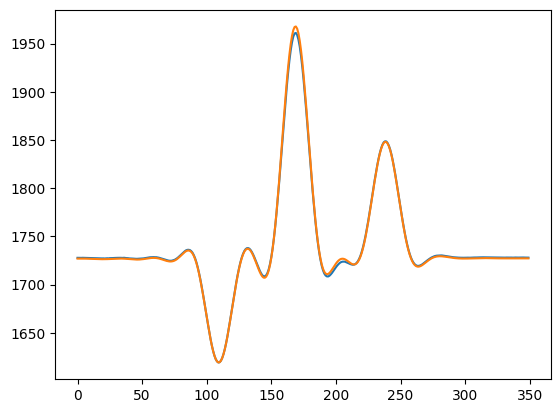

In [ ]:
# Plot comparison of predicted Vs vs True Vs for trace index 125
plt.plot(PredVS[125,:], label='Predicted Vs')
plt.plot(model_EI[125,:,1], label='True Vs')
plt.legend()
plt.show()

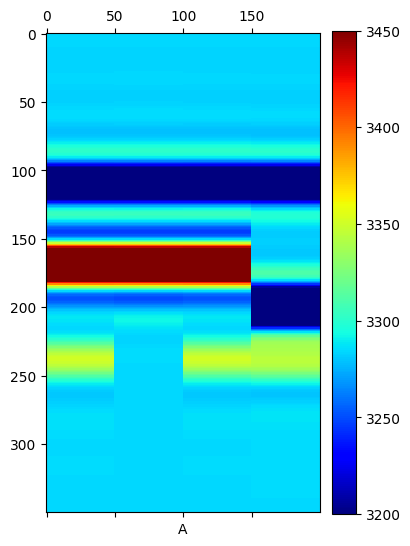

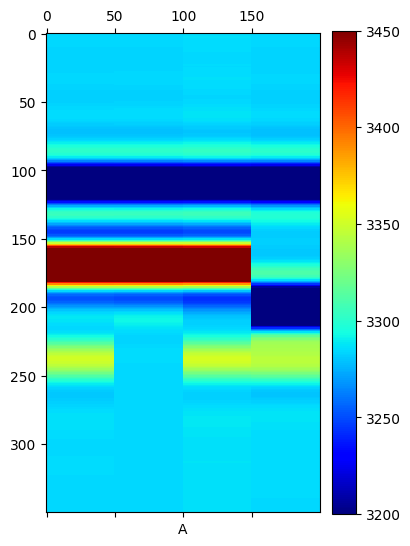

In [ ]:
# Visualize Ground Truth vs Predicted Vp Sections
# Ground Truth Vp
plt.matshow(model_EI[:,:,0].T,cmap ='jet',vmin = 3200,vmax = 3450)
plt.title('True Vp Model')
plt.xlabel('Trace Number (A)')
cb = plt.colorbar(fraction=0.078, pad=0.04)   
plt.show()

# Predicted Vp
plt.matshow(PredVP.T,cmap ='jet',vmin = 3200,vmax = 3450)
plt.title('Predicted Vp Model')
plt.xlabel('Trace Number (A)')
cb = plt.colorbar(fraction=0.078, pad=0.04)   
plt.show()

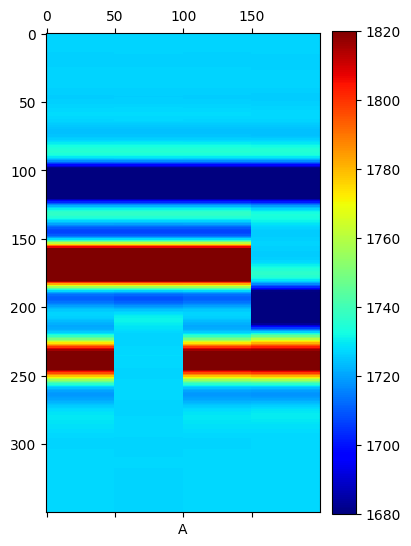

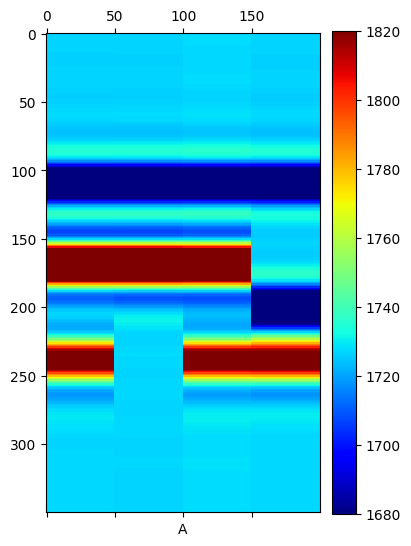

In [ ]:
# Visualization Module: S-wave Velocity (Vs) Comparison
# Top: Ground Truth Vs Section
# Bottom: Predicted Vs Section using the trained model
plt.matshow(model_EI[:,:,1].T,cmap ='jet',vmin = 1680,vmax = 1820)
plt.title('True Vs Model')
plt.xlabel('Trace Number (A)')
cb = plt.colorbar(fraction=0.078, pad=0.04)   # 
plt.show()

plt.matshow(PredVS.T,cmap ='jet',vmin = 1680,vmax = 1820)
plt.title('Predicted Vs Model')
plt.xlabel('Trace Number (A)')
cb = plt.colorbar(fraction=0.078, pad=0.04)   # 
plt.show()

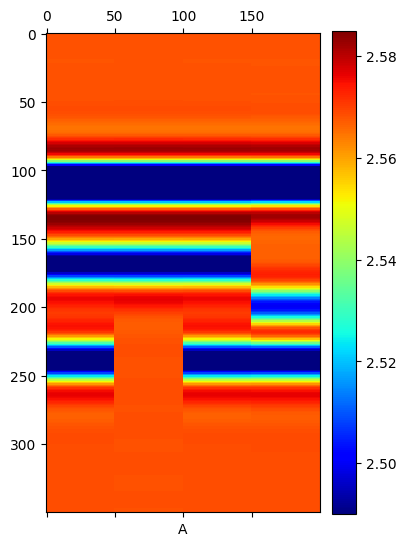

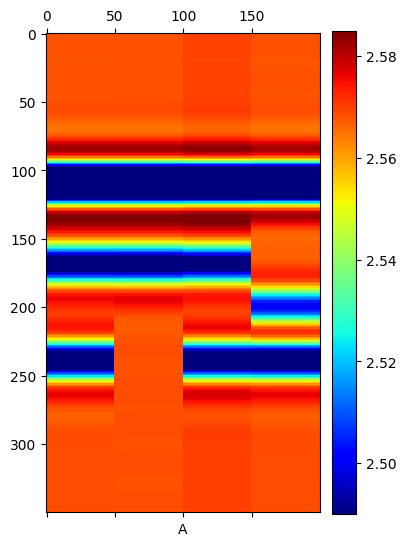

In [ ]:
# Visualization Module: Density Comparison
# Top: Ground Truth Density Section
# Bottom: Predicted Density Section using the trained model
plt.matshow(model_EI[:,:,2].T,cmap ='jet',vmin = 2.49,vmax = 2.585)
plt.title('True Density Model')
plt.xlabel('Trace Number (A)')
cb = plt.colorbar(fraction=0.078, pad=0.04)   # 
plt.show()

plt.matshow(PredDN.T,cmap ='jet',vmin = 2.49,vmax = 2.585)
plt.title('Predicted Density Model')
plt.xlabel('Trace Number (A)')
cb = plt.colorbar(fraction=0.078, pad=0.04)   # 
plt.show()